##### Second Capstone Project
## KKBox's Churn Prediction Challenge

>In this challenge, we were asked to predict whether a user will churn after his/her subscription expires. Specifically, we want to forecast if a user make a new service subscription transaction within 30 days after the current membership expiration date.

>KKBOX offers subscription based music streaming service. When users signs up for our service, users can choose to either manual renew or auto-renew the service. Users can actively cancel their membership at any time.

>The churn/renewal definition can be tricky due to KKBox's subscription model. Since the majority of KKBox's subscription length is 30 days, a lot of users re-subscribe every month. The key fields to determine churn/renewal are transaction date, membership expiration date, and is_cancel. Note that the is_cancel field indicates whether a user actively cancels a subscription. Subscription cancellation does not imply the user has churned. A user may cancel service subscription due to change of service plans or other reasons. The criteria of "churn" is no new valid service subscription within 30 days after the current membership expires.

### Tables
1. ***train.csv***

>the train set, containing the user ids and whether they have churned.

* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

2. ***train_v2.csv***


>same format as sample_submission_zero.csv, refreshed 11/06/2017, contains the test data for April, 2017.

3. ***transactions.csv***

>transactions of users up until 2/28/2017.

* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.

4. ***transactions_v2.csv***

>same format as transactions.csv, refreshed 11/06/2017, contains the transactions data until 3/31/2017.

5. ***user_logs.csv***

>daily user logs describing listening behaviors of a user. Data collected until 2/28/2017.

* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played

6. ***user_logs_v2.csv***

>same format as user_logs.csv, refreshed 11/06/2017, contains the user logs data until 3/31/2017.

7. ***members.csv***

>user information. Note that not every user in the dataset is available.

* msno
* city
* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

8. ***members_v3.csv***

>Refreshed 11/13/2017, replaces members.csv data with the expiration date data removed.

In [1]:
# # Change your working directory to where the data resides1Q
import os
os.chdir('/home/rene/Capstone2 b/Data')
import pandas as pd
import numpy as np
import seaborn as sns
import dask
import dask.dataframe as dd
import xgboost as xgb
import dask_ml
from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import *
from matplotlib import pyplot as plt
import data_prep
%matplotlib inline

pd.options.display.max_columns= None
pd.options.display.max_rows = None

pd.options.display.width=None

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=12)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:46719' processes=1 threads=12, memory=33.52 GB>

## Inital Data Preparation

### Train and Test separation.
To avoid data leakage, we will start by separating the records that belongs to the test and train sets. 

In [2]:
from sklearn.model_selection import train_test_split

trainfull_df = pd.read_csv('train_v2 .csv')


X = trainfull_df['msno']
y=trainfull_df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(  X, y, test_size=0.20)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train = pd.DataFrame(X_train)
X_train.to_parquet('X_train.parquet.gzip', engine='pyarrow', compression='gzip')
X_test = pd.DataFrame(X_test)
X_test.to_parquet('X_test.parquet.gzip', engine='pyarrow', compression='gzip')
y_train = pd.DataFrame(y_train)
y_train.to_parquet('y_train.parquet.gzip', engine='pyarrow', compression='gzip')
y_test = pd.DataFrame(y_test)
y_test.to_parquet('y_test.parquet.gzip', engine='pyarrow', compression='gzip')

In [3]:
%%time
transactions_df = dd.read_csv('transactions.csv', blocksize=50e6)
transactions_v2_df = dd.read_csv('transactions_v2.csv', blocksize=50e6)
transactions_df = dd.concat([transactions_df, transactions_v2_df])
train_transactions_full_df = transactions_df.merge(X_train,on='msno')
train_transactions_agg= train_transactions_full_df.pipe(data_prep.trans_to_datetime).pipe(data_prep.new_transaction_features).pipe(data_prep.transaction_group_agg)
train_transactions_agg.to_parquet('train_transactions_agg.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 2.17 s, sys: 321 ms, total: 2.49 s
Wall time: 1min 17s


In [4]:
%%time
X_test = pd.read_parquet('X_test.parquet.gzip', engine='pyarrow')
X_test = pd.DataFrame(X_test)
transactions_df = dd.read_csv('transactions.csv', blocksize=50e6)
transactions_v2_df = dd.read_csv('transactions_v2.csv', blocksize=50e6)
transactions_df = dd.concat([transactions_df, transactions_v2_df])
test_transactions_full_df = transactions_df.merge(X_test,on='msno')
test_transactions_agg = test_transactions_full_df.pipe(data_prep.trans_to_datetime).pipe(data_prep.new_transaction_features).pipe(data_prep.transaction_group_agg)
test_transactions_agg.to_parquet('test_transactions_agg.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 892 ms, sys: 94.1 ms, total: 986 ms
Wall time: 28.3 s


In [5]:
%%time
user_logs_ddf = dd.read_csv('user_logs.csv', blocksize=250e6)
user_logs_v2_ddf = dd.read_csv('user_logs_v2.csv', blocksize=250e6)
user_logs_ddf = dd.concat([user_logs_ddf, user_logs_v2_ddf])
X_train = dd.read_parquet('X_train.parquet.gzip', chunksize=25)

CPU times: user 382 ms, sys: 39.6 ms, total: 422 ms
Wall time: 783 ms


In [6]:
%%time
train_user_logs_ddf = user_logs_ddf.merge(X_train, on='msno')
train_user_logs_ddf
train_logs_agg = train_user_logs_ddf.pipe(data_prep.new_log_features).pipe(data_prep.log_to_datetime).pipe(data_prep.log_group_agg)
train_logs_agg.to_parquet('train_logs_agg.parquet.gzip', engine='pyarrow', compression='gzip') 

CPU times: user 23.1 s, sys: 2.41 s, total: 25.6 s
Wall time: 8min 9s


In [7]:
%%time
user_logs_ddf = dd.read_csv('user_logs.csv', blocksize=250e6)
user_logs_v2_ddf = dd.read_csv('user_logs_v2.csv', blocksize=250e6)
user_logs_ddf = dd.concat([user_logs_ddf, user_logs_v2_ddf])
X_test = dd.read_parquet('X_test.parquet.gzip', chunksize=25)
test_user_logs_ddf = user_logs_ddf.merge(X_test, on='msno')
test_logs_agg = test_user_logs_ddf.pipe(data_prep.new_log_features).pipe(data_prep.log_to_datetime).pipe(data_prep.log_group_agg)
test_logs_agg.to_parquet('test_logs_agg.parquet.gzip', engine='pyarrow', compression='gzip') 

CPU times: user 13.1 s, sys: 972 ms, total: 14.1 s
Wall time: 3min 43s


In [8]:
%%time
members_v3_df = dd.read_csv('members_v3.csv', blocksize=250e6)

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 26.3 ms


In [9]:
%%time
test_transaction_ddf = dd.read_parquet('test_transactions_agg.parquet.gzip', engine='pyarrow', chunksize=25)
test_logs_ddf = dd.read_parquet('test_logs_agg.parquet.gzip', engine='pyarrow', chunksize=25)

CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 44.3 ms


In [10]:
%%time
def members_merge(ddf1, ddf2, ddf3):
    ddf = dd.merge(ddf1, ddf2, on='msno')
    ddf = dd.merge(ddf, ddf3, on='msno')
    return ddf

CPU times: user 0 ns, sys: 3 µs, total: 3 µs
Wall time: 6.2 µs


In [11]:
%%time
def members_to_timedate(ddf):
    ddf["registration_init_time"]= dd.to_datetime( ddf["registration_init_time"], format='%Y%m%d', errors='coerce')
    ddf["registration_init_year"]=  ddf["registration_init_time"].dt.year
    ddf["registration_init_month"]=  ddf["registration_init_time"].dt.month
    ddf["registration_init_day"]=  ddf["registration_init_time"].dt.day
    ddf["max_transaction_year"]=  ddf["max_transaction_date"].dt.year
    ddf["max_transaction_month"]=  ddf["max_transaction_date"].dt.month
    ddf["max_transaction_day"]=  ddf["max_transaction_date"].dt.day
    ddf["account_age"]=  ddf["max_transaction_date"].dt.year -  ddf["registration_init_time"].dt.year
    return ddf

CPU times: user 81 µs, sys: 0 ns, total: 81 µs
Wall time: 29.6 µs


In [12]:
%%time
test_ddf = members_merge(members_v3_df, test_transaction_ddf, test_logs_ddf ).pipe(members_to_timedate)

CPU times: user 143 ms, sys: 8.84 ms, total: 152 ms
Wall time: 139 ms


In [13]:
%%time
test_ddf.to_parquet('test_members_logs_trans.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 192 ms, sys: 16 ms, total: 208 ms
Wall time: 11.9 s


In [14]:
%%time
train_transaction_ddf = dd.read_parquet('train_transactions_agg.parquet.gzip', engine='pyarrow', chunksize=25)
train_logs_ddf = dd.read_parquet('train_logs_agg.parquet.gzip', engine='pyarrow', chunksize=25)

CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 36.9 ms


In [15]:
%%time
train_ddf = members_merge(members_v3_df, train_transaction_ddf, train_logs_ddf ).pipe(members_to_timedate)

CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 120 ms


In [16]:
%%time
train_ddf.to_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 406 ms, sys: 42.3 ms, total: 449 ms
Wall time: 27.5 s


In [17]:
%%time
train_ddf.head()

CPU times: user 138 ms, sys: 31.1 ms, total: 169 ms
Wall time: 8.9 s


msno  city  bd  gender  \
0  yLkV2gbZ4GLFwqTOXLVHz0VGrMYcgBGgKZ3kj9RiYu8=     4  30    male   
1  I0yFvqMoNkM8ZNHb617e1RBzIS/YRKemHO7Wj13EtA0=    13  63    male   
2  OoDwiKZM+ZGr9P3fRivavgOtglTEaNfWJO4KaJcTTts=     1   0     NaN   
3  4De1jAxNRABoyRBDZ82U0yEmzYkqeOugRGVNIf92Xb8=     4  28  female   
4  GqYHRxlZChiZvB1uzR410wcQzuxqZNZci4AzOTzkAao=     5  27    male   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               9             2011-09-16              39              39   
1               9             2011-09-18              40              40   
2               7             2011-09-18              41              41   
3               9             2011-09-20              31              36   
4               9             2011-09-27              39              39   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0             39.0        0.000000             819              0   
1             40.0        0.000000            1080              0   
2             41.0        0.000000            1107              0   
3             35.0        2.108185             350              0   
4             39.0        0.000000             819              0   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             31       28.714286       6.588952            603   
1             31       29.000000       5.804508            783   
2             30       28.888889       5.773503            780   
3             30       27.000000       9.486833            270   
4             31       28.714286       6.588952            603   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0               0             149       141.904762       32.514466   
1               0             149       143.481481       28.675063   
2               0             149       143.481481       28.675063   
3               0             180       158.900000       56.675391   
4               0             149       141.904762       32.514466   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0            2980              149              149             149.0   
1            3874              149              149             149.0   
2            3874              149              149             149.0   
3            1589              149              180             173.8   
4            2980              149              149             149.0   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0         0.000000             3129          1           21   
1         0.000000             4023          1           27   
2         0.000000             4023          1           27   
3        13.070748             1738          1           10   
4         0.000000             3129          1           21   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2015-02-17           2017-03-31                      21   
1           2015-01-27           2017-03-27                      27   
2           2015-01-26           2017-03-26                      27   
3           2015-03-31           2017-03-03                      10   
4           2015-01-31           2017-03-31                      21   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2015-03-17      2017-05-17              0               21   
1      2015-02-26      2017-04-26              0               27   
2      2015-02-27      2017-04-27              0               27   
3      2015-04-30      2017-04-02              1               10   
4      2015-03-31      2017-05-31              0               21   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        0                         21                -319   
1                        0                         27                -336   
2                        0                     

## Exploratory Data Analisys

In [1]:
# # Change your working directory to where the data resides1Q
import os
os.chdir('/home/rene/Capstone2 b/Data')
import pandas as pd
import numpy as np
import seaborn as sns
import dask
import dask.dataframe as dd
import xgboost as xgb
import dask_ml
from dask_ml.preprocessing import Categorizer, DummyEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import *
from matplotlib import pyplot as plt
import data_prep
%matplotlib inline

pd.options.display.max_columns= None
pd.options.display.max_rows = None

pd.options.display.width=None

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=12)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:45947' processes=1 threads=12, memory=33.52 GB>

In [2]:
y_train = dd.read_parquet('y_train.parquet.gzip', engine='pyarrow')
y_train.head()

is_churn
537816         0
119255         0
284279         0
453905         0
251997         0

<AxesSubplot:xlabel='is_churn', ylabel='count'>

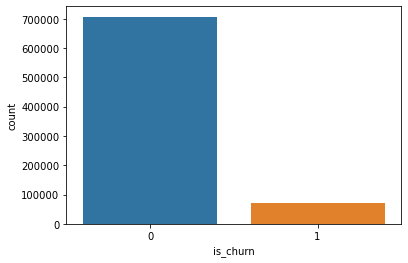

In [3]:
sns.countplot(x=y_train['is_churn'].compute())

The above visualization confirms that we are dealing  with an imbalance clasification task.

Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like churn uplift. This is
the foundational challenge of imbalanced classification.


In [4]:

%%time
X_train = dd.read_parquet('X_train.parquet.gzip', engine = 'pyarrow')
#read from parquet in case kernel needs to restart.

CPU times: user 4.8 ms, sys: 4.95 ms, total: 9.74 ms
Wall time: 7.6 ms


In [5]:
%%time
X_train.head()

CPU times: user 13.3 ms, sys: 4.34 ms, total: 17.7 ms
Wall time: 440 ms


msno
537816  Tfxb6W7XQhFZ6ywHQfskQxr50xR8gfOW4MEQi6YSS4w=
119255  Ov3r89x7vzu/5qcpX/dfitSp9pz3ljwZda8ucshH+80=
284279  JoXnKa/gRLM9aN0h9c1hfILSyS/1Lj+lDZxtFY3xdWw=
453905  bLNuRSuFLVxJbanUjQy2f83otRP5ZtYxRN2yKyvBJ4E=
251997  Q7DmM7gKLo1Z+5DrtER/IGN/woIjcfnTetXkLGNgx7U=

In [6]:
%%time
X_train = X_train.merge(dd.read_parquet('y_train.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)
X_train.head()

CPU times: user 30.9 ms, sys: 4.65 ms, total: 35.5 ms
Wall time: 523 ms


msno  is_churn
537816  Tfxb6W7XQhFZ6ywHQfskQxr50xR8gfOW4MEQi6YSS4w=         0
119255  Ov3r89x7vzu/5qcpX/dfitSp9pz3ljwZda8ucshH+80=         0
284279  JoXnKa/gRLM9aN0h9c1hfILSyS/1Lj+lDZxtFY3xdWw=         0
453905  bLNuRSuFLVxJbanUjQy2f83otRP5ZtYxRN2yKyvBJ4E=         0
251997  Q7DmM7gKLo1Z+5DrtER/IGN/woIjcfnTetXkLGNgx7U=         0

In [7]:
%%time
X_train = X_train.merge(dd.read_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')
X_train

CPU times: user 65.7 ms, sys: 8.38 ms, total: 74.1 ms
Wall time: 68.9 ms


Dask DataFrame Structure:
                 msno is_churn   city     bd  gender registered_via registration_init_time min_payment_id max_payment_id mean_payment_id std_payment_id sum_payment_id min_plan_days max_plan_days mean_plan_days std_plan_days sum_plan_days min_price_list max_price_list mean_price_list std_price_list sum_price_list min_amount_paid max_amount_paid mean_amount_paid std_amount_paid sum_amount_paid max_renew count_renew min_transaction_date max_transaction_date count_transaction_date min_expire_date max_expire_date max_is_cancel count_is_cancel max_auto_renew_&_cancel count_auto_renew_&_cancel min_days_to_expire max_days_to_expire mean_days_to_expire std_days_to_expire sum_days_to_expire min_unpaid max_unpaid mean_unpaid std_unpaid sum_unpaid min_pmethod_renew max_pmethod_renew mean_pmethod_renew std_pmethod_renew sum_pmethod_renew        min_date        max_date count_date min_num_25 max_num_25 mean_num_25 std_num_25 sum_num_25 min_num_50 max_num_50 mean_num_50 std_num_50 sum_num_50 min_num_75 max_num_75 mean_num_75 std_num_75 sum_num_75 min_num_985 max_num_985 mean_num_985 std_num_985 sum_num_985 min_num_100 max_num_100 mean_num_100 std_num_100 sum_num_100 min_num_unq max_num_unq mean_num_unq std_num_unq sum_num_unq min_total_secs max_total_secs mean_total_secs std_total_secs sum_total_secs min_skip_ratio max_skip_ratio mean_skip_ratio std_skip_ratio sum_skip_ratio min_skip25_ratio max_skip25_ratio mean_skip25_ratio std_skip25_ratio sum_skip25_ratio min_skip50_ratio max_skip50_ratio mean_skip50_ratio std_skip50_ratio sum_skip50_ratio min_skip75_ratio max_skip75_ratio mean_skip75_ratio std_skip75_ratio sum_skip75_ratio min_skip985_ratio max_skip985_ratio mean_skip985_ratio std_skip985_ratio sum_skip985_ratio min_num100_ratio max_num100_ratio mean_num100_ratio std_num100_ratio sum_num100_ratio min_unq_ratio max_unq_ratio mean_unq_ratio std_unq_ratio sum_unq_ratio min_unq_secs_ratio max_unq_secs_ratio mean_unq_secs_ratio std_unq_secs_ratio sum_unq_secs_ratio min_num100_secs_ratio max_num100_secs_ratio mean_num100_secs_ratio std_num100_secs_ratio sum_num100_secs_ratio min_skip_secs_ratio max_skip_secs_ratio mean_skip_secs_ratio std_skip_secs_ratio sum_skip_secs_ratio min_skip25_secs_ratio max_skip25_secs_ratio mean_skip25_secs_ratio std_skip25_secs_ratio sum_skip25_secs_ratio min_skip50_secs_ratio max_skip50_secs_ratio mean_skip50_secs_ratio std_skip50_secs_ratio sum_skip50_secs_ratio min_skip75_secs_ratio max_skip75_secs_ratio mean_skip75_secs_ratio std_skip75_secs_ratio sum_skip75_secs_ratio min_skip985_secs_ratio max_skip985_secs_ratio mean_skip985_secs_ratio std_skip985_secs_ratio sum_skip985_secs_ratio min_daily_listening_ratio max_daily_listening_ratio mean_daily_listening_ratio std_daily_listening_ratio sum_daily_listening_ratio registration_init_year registration_init_month registration_init_day max_transaction_year max_transaction_month max_transaction_day account_age
npartitions=2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [14]:
%%time
X_train.head()

CPU times: user 307 ms, sys: 52.9 ms, total: 360 ms
Wall time: 11.1 s


msno  is_churn  city  bd  gender  \
0  Tfxb6W7XQhFZ6ywHQfskQxr50xR8gfOW4MEQi6YSS4w=         0     1   0    None   
1  Ov3r89x7vzu/5qcpX/dfitSp9pz3ljwZda8ucshH+80=         0     1   0    None   
2  JoXnKa/gRLM9aN0h9c1hfILSyS/1Lj+lDZxtFY3xdWw=         0     1   0    None   
3  bLNuRSuFLVxJbanUjQy2f83otRP5ZtYxRN2yKyvBJ4E=         0     4  41    male   
4  x++4gwF33gYuopnh7TflAojG9btuqcdpUfAe/oHQm4Q=         0    15  34  female   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               7             2017-02-13              41              41   
1               3             2013-02-10              35              36   
2               4             2015-10-14              36              36   
3               9             2009-09-28              34              34   
4               3             2014-04-06              40              40   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0           41.000        0.000000              82             30   
1           35.875        0.353553             287              7   
2           36.000        0.000000             576             30   
3           34.000        0.000000             782              0   
4           40.000        0.000000             800              0   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             30       30.000000       0.000000             60   
1             30       27.125000       8.131728            217   
2             30       30.000000       0.000000            480   
3             30       22.173913      13.469333            510   
4             31       28.650000       6.753362            573   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0             100             100       100.000000        0.000000   
1               0             180       157.500000       63.639610   
2             150             180       172.500000       13.416408   
3               0             149       110.130435       66.897686   
4               0             149       141.550000       33.317413   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0             200              100              100             100.0   
1            1260                0              180             157.5   
2            2760              150              180             172.5   
3            2533              149              149             149.0   
4            2831              149              149             149.0   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0         0.000000              200          1            2   
1        63.639610             1260          0            8   
2        13.416408             2760          1           16   
3         0.000000             3427          1           23   
4         0.000000             2980          1           20   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2017-02-13           2017-03-12                       2   
1           2016-08-28           2017-03-03                       8   
2           2015-11-24           2017-03-17                      16   
3           2015-03-31           2017-03-31                      23   
4           2015-02-01           2017-03-01                      20   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2017-03-12      2017-04-12              0                2   
1      2016-09-02      2017-04-02              0                8   
2      2015-12-24      2017-04-16              0               16   
3      2015-04-30      2017-04-30              0               23   
4      2015-02-28      2017-04-06              0               20   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        0                          2                  27   
1                        0                          8           

In [9]:
%%time
X_train.describe().compute().T

CPU times: user 1.87 s, sys: 111 ms, total: 1.98 s
Wall time: 14.5 s


count          mean           std  \
is_churn                    684159.0  9.457305e-02  2.926245e-01   
city                        684159.0  5.947097e+00  6.441281e+00   
bd                          684159.0  1.359107e+01  1.970753e+01   
registered_via              684159.0  6.889344e+00  1.941480e+00   
min_payment_id              684159.0  3.799515e+01  4.781925e+00   
max_payment_id              684159.0  3.906847e+01  3.289784e+00   
mean_payment_id             684159.0  3.872768e+01  3.612218e+00   
std_payment_id              678482.0  4.200694e-01  1.348488e+00   
sum_payment_id              684159.0  6.642397e+02  3.564583e+02   
min_plan_days               684159.0  2.250827e+01  3.483973e+01   
max_plan_days               684159.0  4.428542e+01  6.221545e+01   
mean_plan_days              684159.0  3.477401e+01  3.528453e+01   
std_plan_days               678482.0  7.123533e+00  2.282586e+01   
sum_plan_days               684159.0  5.125997e+02  2.502405e+02   
min_price_list              684159.0  9.073771e+01  1.472641e+02   
max_price_list              684159.0  1.962307e+02  2.676049e+02   
mean_price_list             684159.0  1.522335e+02  1.504846e+02   
std_price_list              678482.0  3.466030e+01  9.897864e+01   
sum_price_list              684159.0  2.306500e+03  1.256958e+03   
min_amount_paid             684159.0  1.289182e+02  1.369066e+02   
max_amount_paid             684159.0  1.967596e+02  2.701164e+02   
mean_amount_paid            684159.0  1.552276e+02  1.504875e+02   
std_amount_paid             678482.0  2.599199e+01  1.002115e+02   
sum_amount_paid             684159.0  2.382255e+03  1.314750e+03   
max_renew                   684159.0  8.841264e-01  3.200736e-01   
count_renew                 684159.0  1.701335e+01  8.867276e+00   
count_transaction_date      684159.0  1.701335e+01  8.867276e+00   
max_is_cancel               684159.0  2.496189e-01  4.327928e-01   
count_is_cancel             684159.0  1.701335e+01  8.867276e+00   
max_auto_renew_&_cancel     684159.0  2.496189e-01  4.327928e-01   
count_auto_renew_&_cancel   684159.0  1.701335e+01  8.867276e+00   
min_days_to_expire          684159.0 -2.968295e+02  1.058868e+02   
max_days_to_expire          684159.0  4.127299e+01  3.816268e+01   
mean_days_to_expire         684159.0 -3.892482e+00  2.258988e+01   
std_days_to_expire          678482.0  1.067854e+02  3.940117e+01   
sum_days_to_expire          684159.0 -3.162448e+01  1.986355e+02   
min_unpaid                  684159.0 -4.898464e+01  8.191882e+01   
max_unpaid                  684159.0  8.300359e+00  3.207234e+01   
mean_unpaid                 684159.0 -2.994045e+00  1.268696e+01   
std_unpaid                  678482.0  1.457912e+01  2.578833e+01   
sum_unpaid                  684159.0 -7.575453e+01  2.243656e+02   
min_pmethod_renew           684159.0  3.075852e+01  1.654630e+01   
max_pmethod_renew           684159.0  3.478751e+01  1.295029e+01   
mean_pmethod_renew          684159.0  3.360750e+01  1.342903e+01   
std_pmethod_renew           678482.0  1.577585e+00  4.651949e+00   
sum_pmethod_renew           684159.0  6.100865e+02  3.973261e+02   
count_date                  684159.0  2.928824e+02  2.323540e+02   
min_num_25                  684159.0  9.413601e-02  1.538770e+00   
max_num_25                  684159.0  7.193518e+01  8.042451e+01   
mean_num_25                 684159.0  5.949179e+00  6.443084e+00   
std_num_25                  676612.0  9.030640e+00  8.732072e+00   
sum_num_25                  684159.0  1.905807e+03  3.096771e+03   
min_num_50                  684159.0  1.694928e-02  3.696685e-01   
max_num_50                  684159.0  2.358057e+01  3.104602e+01   
mean_num_50                 684159.0  1.492073e+00  1.463378e+00   
std_num_50                  676612.0  2.709706e+00  2.843728e+00   
sum_num_50                  684159.0  4.726161e+02  6.573463e+02   
min_num_75                  684159.0  7.186926e-03  2.182404e-01   
max_num_75         

In [10]:
%%time
global_mean = X_train.is_churn.mean().compute()
round(global_mean, 3)

CPU times: user 239 ms, sys: 44.1 ms, total: 283 ms
Wall time: 10.9 s


0.095

* **As we can appreciate above, the proportion of churrned users or the probability that a costumer will churn is approximetly 9.5%.**
* **Again, we can validate that we have a case of an imbalance clasification, since there are 9 times more people that did not churn in our dataset.**

In [11]:

categorical = ['city',  'registered_via', 'gender', 'account_age']

In [12]:
%%time
X_train[categorical].compute().nunique()

CPU times: user 319 ms, sys: 84.7 ms, total: 404 ms
Wall time: 11.1 s


city              21
registered_via     5
gender             2
account_age       14
dtype: int64

## Feature importance

In [13]:
%%time
female_mean = X_train[X_train.gender == 'female'].is_churn.mean().compute()
print('gender == female:', round(female_mean, 3))

male_mean = X_train[X_train.gender == 'male'].is_churn.mean().compute()
print('gender == male:  ', round(male_mean, 3))

gender == female: 0.131
gender == male:   0.129
CPU times: user 583 ms, sys: 95.6 ms, total: 678 ms
Wall time: 23.9 s


On the code above we can see that the churn rate of females is 13.1% and that the rate for males is 13%. Knowing the gender of the client whould help predict churning better since regardles if it is male or female , the churning rate by gender is higher than the global churn rate of 9.5%

In [15]:
%%time
female_mean / global_mean

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


1.3808987058767528

In [16]:

male_mean / global_mean

1.3618362336575178

On the code above we measured the ratio between probabilies, also known as the risk.  Since both groups risk is higher than 1, We can conclude that if we know the gender of the client the risk of churning is higher.  

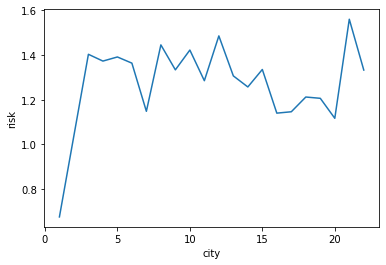

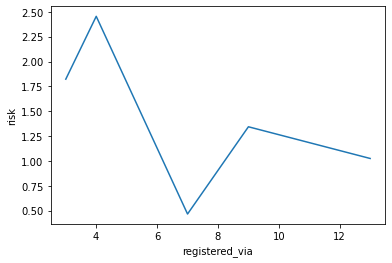

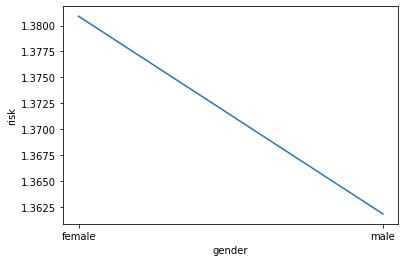

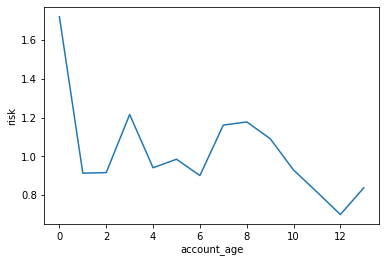

CPU times: user 1.44 s, sys: 67.8 ms, total: 1.51 s
Wall time: 41.5 s


In [17]:
%%time
for col in categorical:
    df_group = X_train.groupby(by=col).is_churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    sns.lineplot(x=col, y="risk",
             data= df_group.compute())
    plt.show()

In [18]:
%%time
for col in categorical:
    df_group = X_train.groupby(by=col).is_churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group.compute())

mean      diff      risk
city                              
1     0.063794 -0.030779  0.674549
3     0.132681  0.038108  1.402950
4     0.129808  0.035235  1.372567
5     0.131549  0.036976  1.390974
6     0.128934  0.034361  1.363329
7     0.108531  0.013958  1.147587
8     0.136669  0.042096  1.445120
9     0.126092  0.031519  1.333272
10    0.134477  0.039904  1.421935
11    0.121494  0.026921  1.284658
12    0.140474  0.045901  1.485350
13    0.123531  0.028958  1.306193
14    0.118844  0.024271  1.256639
15    0.126251  0.031678  1.334962
16    0.107753  0.013180  1.139362
17    0.108339  0.013766  1.145560
18    0.114582  0.020009  1.211568
19    0.114035  0.019462  1.205788
20    0.105566  0.010993  1.116240
21    0.147529  0.052956  1.559948
22    0.126001  0.031427  1.332309

mean      diff      risk
registered_via                              
3               0.172374  0.077801  1.822651
4               0.232092  0.137519  2.454103
7               0.044149 -0.050424  0.466824
9               0.127090  0.032517  1.343834
13              0.096952  0.002379  1.025154

mean      diff      risk
gender                              
female  0.130596  0.036023  1.380899
male    0.128793  0.034220  1.361836

mean      diff      risk
account_age                              
0            0.162619  0.068046  1.719503
1            0.086343 -0.008230  0.912979
2            0.086630 -0.007943  0.916011
3            0.114966  0.020393  1.215632
4            0.088971 -0.005602  0.940763
5            0.093153 -0.001420  0.984989
6            0.085187 -0.009386  0.900749
7            0.109803  0.015230  1.161043
8            0.111344  0.016771  1.177332
9            0.103208  0.008635  1.091306
10           0.087875 -0.006698  0.929174
11           0.077160 -0.017413  0.815880
12           0.066178 -0.028395  0.699758
13           0.079193 -0.015380  0.837372

CPU times: user 1.05 s, sys: 83.4 ms, total: 1.14 s
Wall time: 41.1 s


By calculating the risk on the cities column we can see that city number 1 and city number 20  have risk values lower to 1, meaning that they have lower probability of churning. With regard of the registering methods, method number 7 have the lowest risk while method 4 have the highest risk. Also, we can see how accounts with less than one year old have the highest risk of churning followed by accounts with 3, 8 and 7 years old.

In [19]:
df_group.tail()

mean      diff      risk
account_age                              
9            0.103208  0.008635  1.091306
10           0.087875 -0.006698  0.929174
11           0.077160 -0.017413  0.815880
12           0.066178 -0.028395  0.699758
13           0.079193 -0.015380  0.837372

CPU times: user 5.43 s, sys: 1.13 s, total: 6.56 s
Wall time: 3min 24s


<AxesSubplot:>

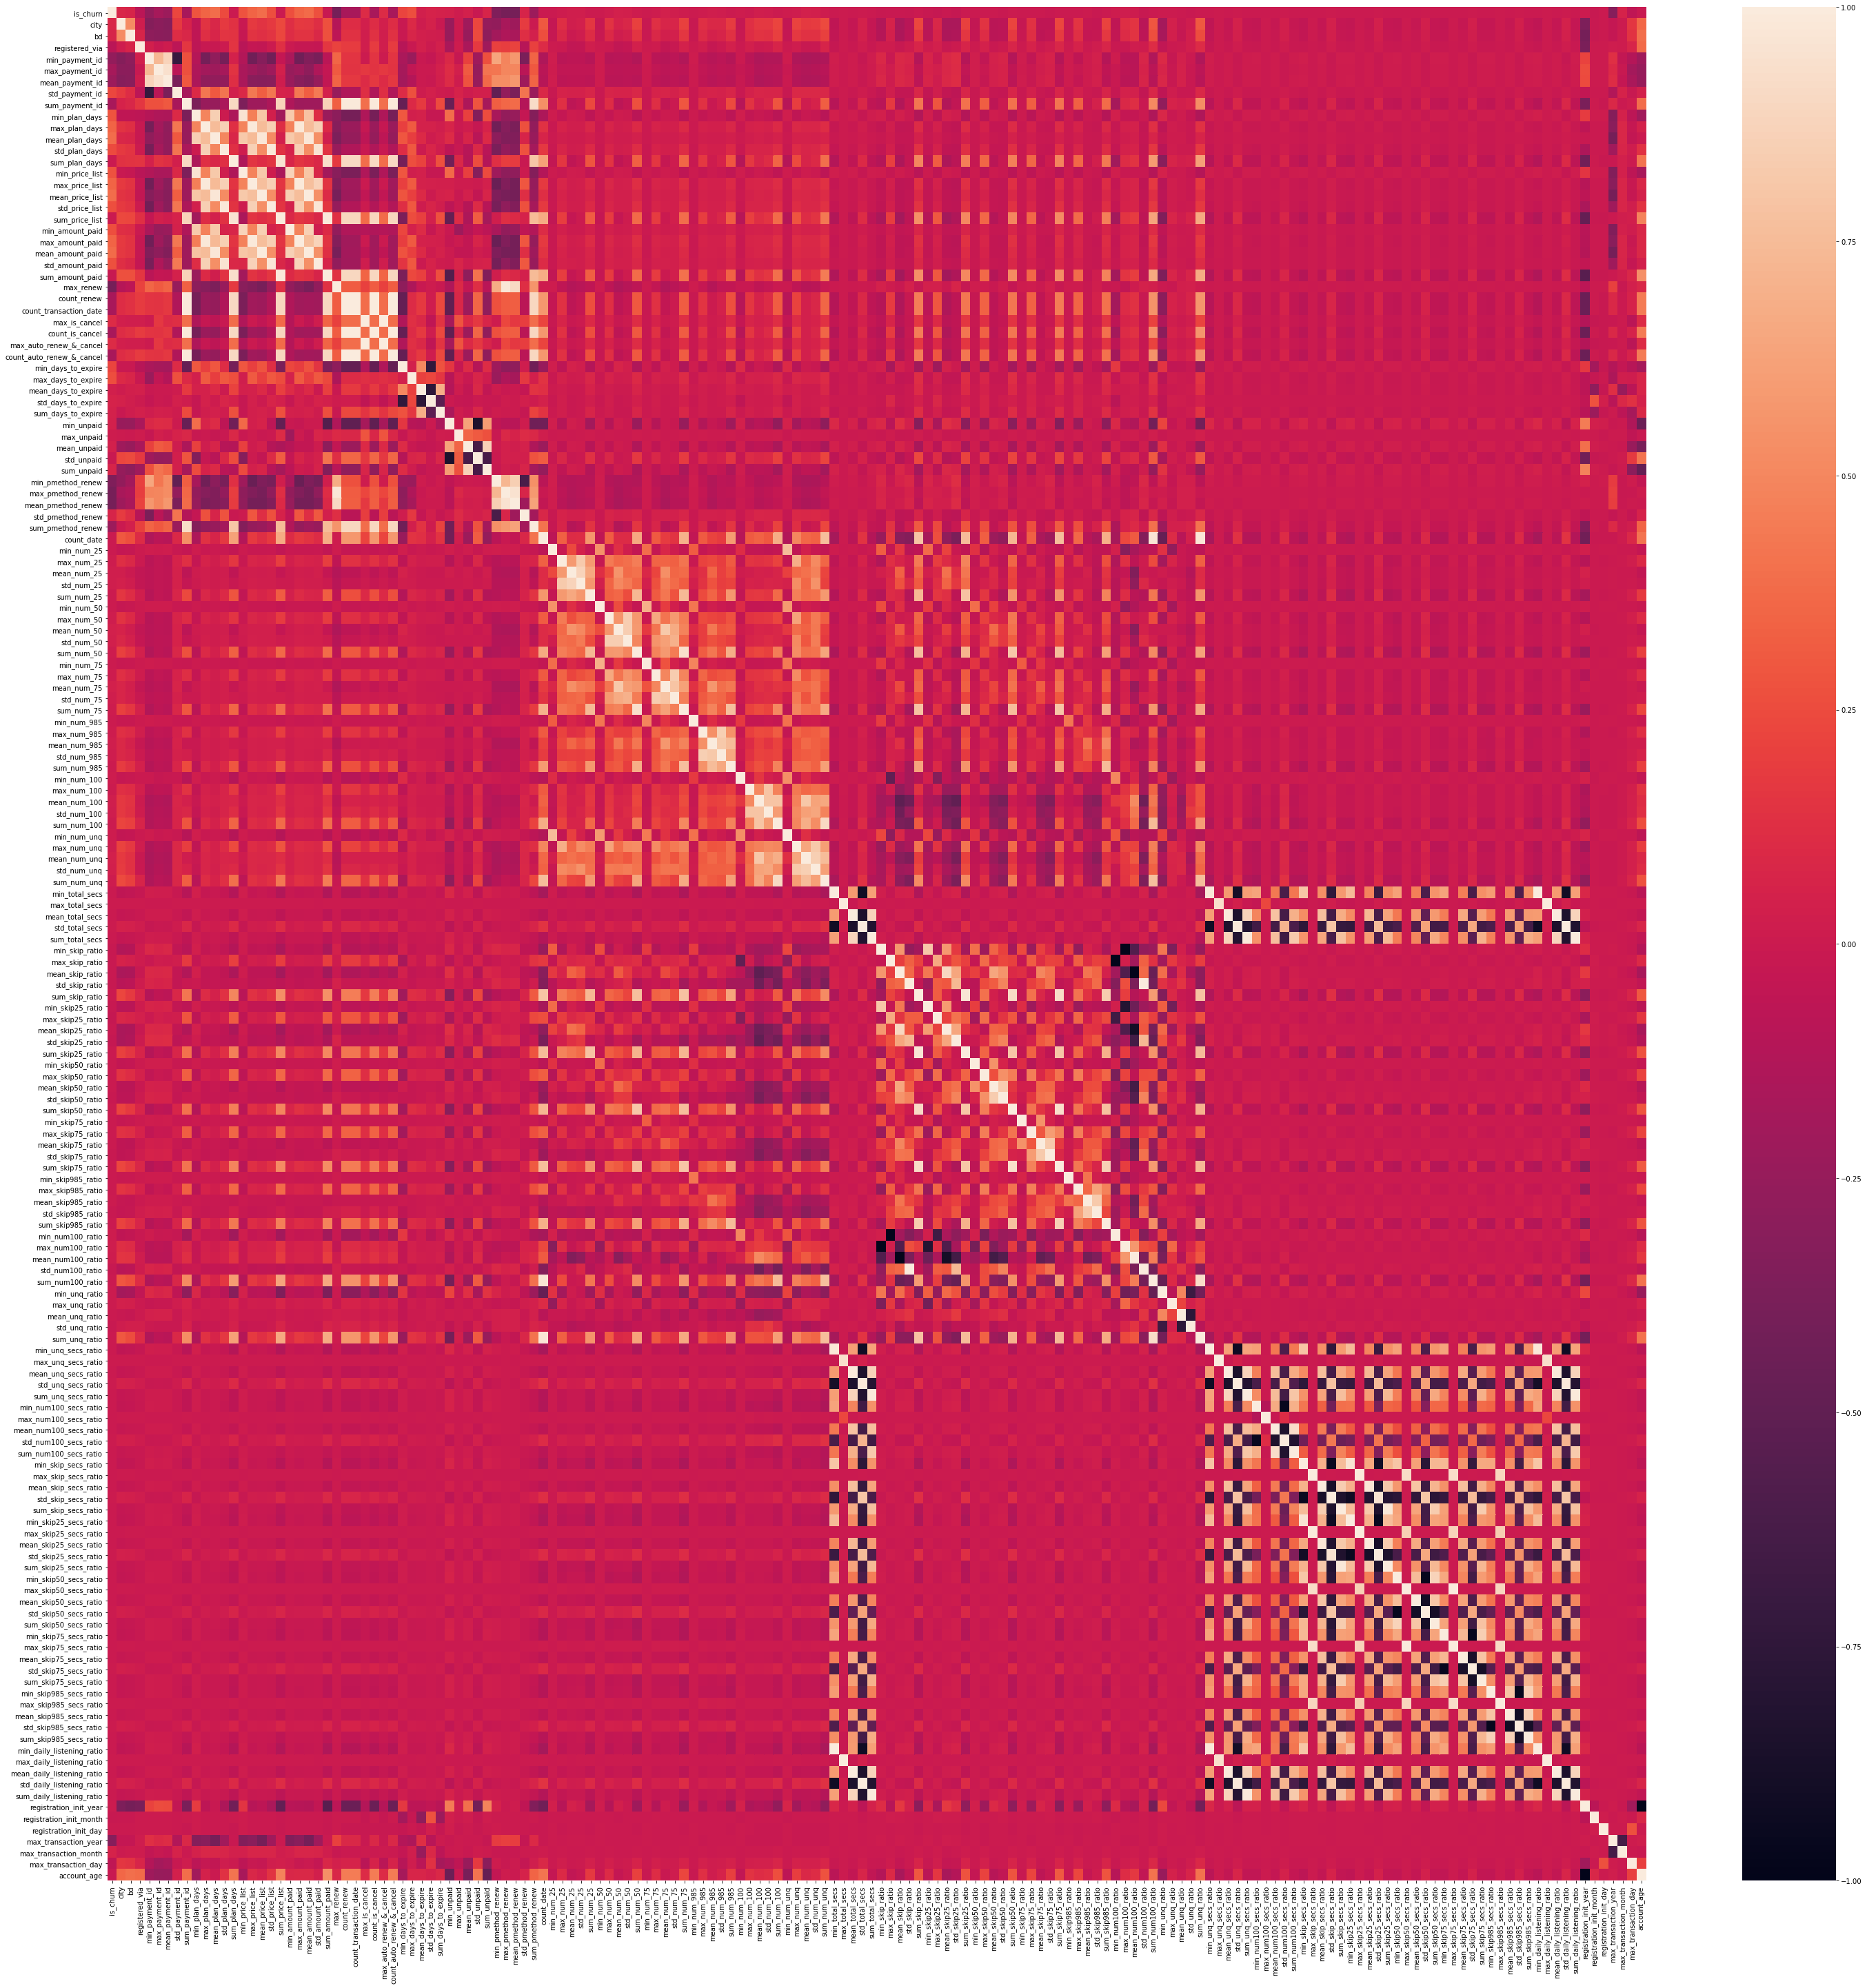

In [19]:
%%time
plt.figure(figsize=(50, 50))
sns.heatmap(X_train.corr().compute())

In [21]:
%%time
train_corr = pd.DataFrame(X_train.corr().compute())

CPU times: user 4.8 s, sys: 159 ms, total: 4.95 s
Wall time: 3min 39s


In [21]:
%%time
train_corr.sort_values(by="is_churn")

CPU times: user 399 µs, sys: 59 µs, total: 458 µs
Wall time: 364 µs


is_churn      city        bd  registered_via  \
max_renew                  -0.403901 -0.102254 -0.067060        0.215242   
mean_pmethod_renew         -0.395874 -0.213756 -0.161941        0.212713   
max_pmethod_renew          -0.395242 -0.170450 -0.136123        0.193192   
min_pmethod_renew          -0.353614 -0.266121 -0.193529        0.204827   
max_transaction_year       -0.322167 -0.036274 -0.034232        0.016771   
min_payment_id             -0.260531 -0.331652 -0.287993        0.037922   
sum_pmethod_renew          -0.222602 -0.006928  0.041256        0.203409   
mean_payment_id            -0.220867 -0.325462 -0.309710        0.012533   
max_payment_id             -0.176337 -0.297664 -0.300801       -0.012034   
sum_payment_id             -0.171032  0.055455  0.080992        0.164010   
count_auto_renew_&_cancel  -0.167430  0.114770  0.139616        0.182832   
count_renew                -0.167430  0.114770  0.139616        0.182832   
count_is_cancel            -0.167430  0.114770  0.139616        0.182832   
count_transaction_date     -0.167430  0.114770  0.139616        0.182832   
registered_via             -0.081367  0.018183  0.066180        1.000000   
max_transaction_day        -0.062097  0.160564  0.146090        0.073632   
std_skip25_ratio           -0.029935 -0.155158 -0.128094        0.004240   
max_skip25_ratio           -0.024303  0.081262  0.068607        0.045428   
registration_init_month    -0.021849 -0.014206 -0.012488        0.000715   
min_skip_ratio             -0.019652 -0.122229 -0.104246        0.009932   
min_skip25_ratio           -0.017362 -0.092167 -0.079422        0.009591   
sum_amount_paid            -0.016229  0.268432  0.270739        0.161613   
std_skip_ratio             -0.015892 -0.088952 -0.073865        0.009427   
std_num100_ratio           -0.015892 -0.088952 -0.073865        0.009427   
mean_skip25_ratio          -0.015361 -0.153033 -0.144794       -0.022882   
std_unq_ratio              -0.015166  0.018619  0.035394        0.037171   
std_skip75_ratio           -0.014960 -0.060725 -0.051025        0.017179   
max_skip_ratio             -0.014888  0.055672  0.040684        0.013355   
std_unpaid                 -0.014091  0.231849  0.244369        0.173389   
account_age                -0.012603  0.360555  0.398339        0.381618   
std_skip50_ratio           -0.011895 -0.075386 -0.071214        0.007493   
mean_skip_ratio            -0.011867 -0.151824 -0.147324       -0.021272   
std_skip985_ratio          -0.011206 -0.031268 -0.028602        0.020741   
max_skip75_ratio           -0.007691  0.140319  0.119380        0.059794   
sum_plan_days              -0.007176  0.134174  0.146545        0.153384   
sum_num100_ratio           -0.006996  0.296441  0.260776        0.109701   
max_skip50_ratio           -0.006633  0.142997  0.116185        0.054552   
min_skip50_ratio           -0.006019 -0.039530 -0.033144        0.005367   
count_date                 -0.006003  0.303671  0.259117        0.108686   
sum_price_list             -0.005591  0.235876  0.232080        0.131560   
min_unq_secs_ratio         -0.005114 -0.060401 -0.051460       -0.024234   
min_daily_listening_ratio  -0.005048 -0.061764 -0.052570       -0.025032   
min_total_secs             -0.005048 -0.061764 -0.052570       -0.025032   
registration_init_day      -0.004649 -0.005514 -0.003027        0.003725   
sum_unq_ratio              -0.004408  0.299137  0.253452        0.104972   
min_skip75_secs_ratio      -0.004312 -0.040548 -0.033100       -0.016022   
max_skip985_ratio          -0.004307  0.155019  0.129453        0.059885   
mean_skip985_secs_ratio    -0.004232 -0.030114 -0.022057       -0.011219   
min_skip_secs_ratio        -0.004179 -0.050663 -0.041621       -0.021107   
min_skip985_secs_ratio     -0.004071 -0.038788 -0.030055       -0.014133   
min_skip50_secs_ratio      -0.003418 -0.039999 -0.031562       -0.016301   
mean_skip75_secs_ratio     -0.003413 -0.028059 -0.021462       -0.011775   


In [ ]:
#selecting rows of feautures of interest
top_corr = train_corr[pow(train_corr['is_churn'],2)>pow(0.49,2)].copy()



The most positive correlated feautures are mean_price_list, mean_plan_days, mean_amount_paid, max_plan_days and max_price_list. Furthermore the mos negative correlated feautures are, max_renew, mean_pmethod_renew (paymemth method that also had auto renew), min_pmethod_renew.

## Data preparation

In [29]:
X_train.dtypes

msno                                  object
is_churn                               int64
city                                   int64
bd                                     int64
gender                                object
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_list                       float64
sum_price_list                         int64
min_amount

In [23]:
%%time
X_test = dd.read_parquet('X_test.parquet.gzip', engine = 'pyarrow')

CPU times: user 3.83 ms, sys: 82 µs, total: 3.91 ms
Wall time: 4.11 ms


In [24]:
%%time
X_test.head()

CPU times: user 5.67 ms, sys: 3.35 ms, total: 9.02 ms
Wall time: 125 ms


msno
462124  VVI6bwi0/CAD6vtBvP1P7CwAW8icAn2k+uHBao2mt5A=
841807  cRWeTCtcxwX93NCJ8ZI925ag1yCE0QrhqHLRlGPx3mw=
383244  y1pFnxTeM6gTsELJfwPJd5vzBPW1LB8mGBbRcu/h1tY=
781796  gYpbJguK8xFMGGxT1CPz9NyGQb4waENHftfXE5T3Huc=
312155  N8tvTeloNBV6mg95W1i9CqWlCGVY2m3XktuzPjjr+BQ=

In [25]:
%%time
X_test = X_test.merge(dd.read_parquet('y_test.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)
X_test.head()

CPU times: user 19.6 ms, sys: 949 µs, total: 20.5 ms
Wall time: 150 ms


msno  is_churn
462124  VVI6bwi0/CAD6vtBvP1P7CwAW8icAn2k+uHBao2mt5A=         0
841807  cRWeTCtcxwX93NCJ8ZI925ag1yCE0QrhqHLRlGPx3mw=         0
383244  y1pFnxTeM6gTsELJfwPJd5vzBPW1LB8mGBbRcu/h1tY=         0
781796  gYpbJguK8xFMGGxT1CPz9NyGQb4waENHftfXE5T3Huc=         0
312155  N8tvTeloNBV6mg95W1i9CqWlCGVY2m3XktuzPjjr+BQ=         0

In [26]:
%%time
X_test =X_test.merge(dd.read_parquet('test_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')
X_test

CPU times: user 42.5 ms, sys: 4.22 ms, total: 46.7 ms
Wall time: 53.2 ms


Dask DataFrame Structure:
                 msno is_churn   city     bd  gender registered_via registration_init_time min_payment_id max_payment_id mean_payment_id std_payment_id sum_payment_id min_plan_days max_plan_days mean_plan_days std_plan_days sum_plan_days min_price_list max_price_list mean_price_list std_price_list sum_price_list min_amount_paid max_amount_paid mean_amount_paid std_amount_paid sum_amount_paid max_renew count_renew min_transaction_date max_transaction_date count_transaction_date min_expire_date max_expire_date max_is_cancel count_is_cancel max_auto_renew_&_cancel count_auto_renew_&_cancel min_days_to_expire max_days_to_expire mean_days_to_expire std_days_to_expire sum_days_to_expire min_unpaid max_unpaid mean_unpaid std_unpaid sum_unpaid min_pmethod_renew max_pmethod_renew mean_pmethod_renew std_pmethod_renew sum_pmethod_renew        min_date        max_date count_date min_num_25 max_num_25 mean_num_25 std_num_25 sum_num_25 min_num_50 max_num_50 mean_num_50 std_num_50 sum_num_50 min_num_75 max_num_75 mean_num_75 std_num_75 sum_num_75 min_num_985 max_num_985 mean_num_985 std_num_985 sum_num_985 min_num_100 max_num_100 mean_num_100 std_num_100 sum_num_100 min_num_unq max_num_unq mean_num_unq std_num_unq sum_num_unq min_total_secs max_total_secs mean_total_secs std_total_secs sum_total_secs min_skip_ratio max_skip_ratio mean_skip_ratio std_skip_ratio sum_skip_ratio min_skip25_ratio max_skip25_ratio mean_skip25_ratio std_skip25_ratio sum_skip25_ratio min_skip50_ratio max_skip50_ratio mean_skip50_ratio std_skip50_ratio sum_skip50_ratio min_skip75_ratio max_skip75_ratio mean_skip75_ratio std_skip75_ratio sum_skip75_ratio min_skip985_ratio max_skip985_ratio mean_skip985_ratio std_skip985_ratio sum_skip985_ratio min_num100_ratio max_num100_ratio mean_num100_ratio std_num100_ratio sum_num100_ratio min_unq_ratio max_unq_ratio mean_unq_ratio std_unq_ratio sum_unq_ratio min_unq_secs_ratio max_unq_secs_ratio mean_unq_secs_ratio std_unq_secs_ratio sum_unq_secs_ratio min_num100_secs_ratio max_num100_secs_ratio mean_num100_secs_ratio std_num100_secs_ratio sum_num100_secs_ratio min_skip_secs_ratio max_skip_secs_ratio mean_skip_secs_ratio std_skip_secs_ratio sum_skip_secs_ratio min_skip25_secs_ratio max_skip25_secs_ratio mean_skip25_secs_ratio std_skip25_secs_ratio sum_skip25_secs_ratio min_skip50_secs_ratio max_skip50_secs_ratio mean_skip50_secs_ratio std_skip50_secs_ratio sum_skip50_secs_ratio min_skip75_secs_ratio max_skip75_secs_ratio mean_skip75_secs_ratio std_skip75_secs_ratio sum_skip75_secs_ratio min_skip985_secs_ratio max_skip985_secs_ratio mean_skip985_secs_ratio std_skip985_secs_ratio sum_skip985_secs_ratio min_daily_listening_ratio max_daily_listening_ratio mean_daily_listening_ratio std_daily_listening_ratio sum_daily_listening_ratio registration_init_year registration_init_month registration_init_day max_transaction_year max_transaction_month max_transaction_day account_age
npartitions=2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [27]:
%%time
X_test.head()

CPU times: user 43.2 ms, sys: 3.46 ms, total: 46.7 ms
Wall time: 1.86 s


msno  is_churn  city  bd  gender  \
0  VVI6bwi0/CAD6vtBvP1P7CwAW8icAn2k+uHBao2mt5A=         0     1   0    None   
1  gYpbJguK8xFMGGxT1CPz9NyGQb4waENHftfXE5T3Huc=         0     1   0    None   
2  7ynFrwh948QkJyM1403wQXK7tXnSrKKLFfi6C35N6h0=         0     1   0    None   
3  ev3CAKEUcYegUZOqPiIHLppSw/kdLqZRPcHyxrrSX/E=         1    11  24  female   
4  Lx0i5/+KXbeP+Ew8FfxBxxBH203R3UQeXaZmV90P1dU=         0    13  30  female   

   registered_via registration_init_time  min_payment_id  max_payment_id  \
0               7             2016-11-17              41              41   
1               7             2011-08-08              41              41   
2               7             2016-02-18              41              41   
3               3             2013-12-23              22              22   
4               3             2013-08-23              40              40   

   mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
0             41.0             0.0             205             30   
1             41.0             0.0            1107             30   
2             41.0             0.0             574             30   
3             22.0             NaN              22            410   
4             40.0             0.0             320             30   

   max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
0             30            30.0            0.0            150   
1             30            30.0            0.0            810   
2             30            30.0            0.0            420   
3            410           410.0            NaN            410   
4             30            30.0            0.0            240   

   min_price_list  max_price_list  mean_price_list  std_price_list  \
0              99              99             99.0             0.0   
1             149             149            149.0             0.0   
2             149             149            149.0             0.0   
3            1788            1788           1788.0             NaN   
4             149             149            149.0             0.0   

   sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
0             495               99               99              99.0   
1            4023              149              149             149.0   
2            2086              149              149             149.0   
3            1788             1788             1788            1788.0   
4            1192              149              149             149.0   

   std_amount_paid  sum_amount_paid  max_renew  count_renew  \
0              0.0              495          1            5   
1              0.0             4023          1           27   
2              0.0             2086          1           14   
3              NaN             1788          0            1   
4              0.0             1192          1            8   

  min_transaction_date max_transaction_date  count_transaction_date  \
0           2016-11-17           2017-03-16                       5   
1           2015-01-18           2017-03-18                      27   
2           2016-02-18           2017-03-18                      14   
3           2016-02-07           2016-02-07                       1   
4           2016-08-03           2017-03-03                       8   

  min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
0      2016-12-16      2017-04-16              0                5   
1      2015-02-19      2017-04-19              0               27   
2      2016-03-18      2017-04-18              0               14   
3      2017-03-26      2017-03-26              0                1   
4      2016-09-02      2017-04-02              0                8   

   max_auto_renew_&_cancel  count_auto_renew_&_cancel  min_days_to_expire  \
0                        0                          5                -335   
1                        0                         27           

In [28]:
X_test['gender'] = X_test['gender'].astype('category') 
X_test['gender'] = X_test['gender'].cat.add_categories('not_specified')
X_test['gender'] = X_test['gender'].fillna('not_specified')
X_test['gender'].head()


0    not_specified
1    not_specified
2    not_specified
3           female
4           female
Name: gender, dtype: category
Categories (3, object): ['female', 'male', 'not_specified']

In [30]:
%%time

X_train = dd.read_parquet('X_train.parquet.gzip', engine = 'pyarrow')

X_train = X_train.merge(dd.read_parquet('y_train.parquet.gzip', engine='pyarrow'),left_index=True, right_index=True)

X_train =X_train.merge(dd.read_parquet('train_members_logs_trans.parquet.gzip', engine='pyarrow'), on='msno')

#read from parquet in case kernel needs to restart.
X_train['gender'] = X_train['gender'].astype('category')
X_train['gender'] = X_train['gender'].cat.add_categories('not_specified')
X_train['gender'] = X_train['gender'].fillna('not_specified')
display(X_train['gender'].head())


0    not_specified
1    not_specified
2    not_specified
3             male
4           female
Name: gender, dtype: category
Categories (3, object): ['female', 'male', 'not_specified']

CPU times: user 250 ms, sys: 1.34 ms, total: 251 ms
Wall time: 7.22 s


In [31]:
%%time
from dask_ml.preprocessing import DummyEncoder
#from dask_ml.compose import ColumnTransformer
de = DummyEncoder()

X = X_train.drop(columns=["msno", "is_churn", "registration_init_time", "min_date", "max_date", "min_transaction_date", "max_transaction_date", "min_expire_date", "max_expire_date"])
Y =  X_train["is_churn"]

X_eval =  X_test.drop(columns=["msno", "is_churn", "registration_init_time", "min_date", "max_date", "min_transaction_date", "max_transaction_date", "min_expire_date", "max_expire_date"])
y_eval = X_test['is_churn']

# determine categorical and numerical features
#categorical_ix = X.select_dtypes(include=['category']).columns
#categories = [X[column].unique() for column in X[categorical_ix]]
#
# define the data preparation for the columns
#t = [( 'cat' , OneHotEncoder(categories=categories,  sparse=False), categorical_ix)]
#col_transform = ColumnTransformer(transformers=t, remainder='passthrough') 
X = X.categorize()
data = de.fit_transform(X)

labels = Y
X_eval = X_eval.categorize()
X_eval = de.transform(X_eval)


CPU times: user 323 ms, sys: 31.3 ms, total: 355 ms
Wall time: 12 s


In [32]:
data.head()

city  bd  registered_via  min_payment_id  max_payment_id  mean_payment_id  \
0     1   0               7              41              41           41.000   
1     1   0               3              35              36           35.875   
2     1   0               4              36              36           36.000   
3     4  41               9              34              34           34.000   
4    15  34               3              40              40           40.000   

   std_payment_id  sum_payment_id  min_plan_days  max_plan_days  \
0        0.000000              82             30             30   
1        0.353553             287              7             30   
2        0.000000             576             30             30   
3        0.000000             782              0             30   
4        0.000000             800              0             31   

   mean_plan_days  std_plan_days  sum_plan_days  min_price_list  \
0       30.000000       0.000000             60             100   
1       27.125000       8.131728            217               0   
2       30.000000       0.000000            480             150   
3       22.173913      13.469333            510               0   
4       28.650000       6.753362            573               0   

   max_price_list  mean_price_list  std_price_list  sum_price_list  \
0             100       100.000000        0.000000             200   
1             180       157.500000       63.639610            1260   
2             180       172.500000       13.416408            2760   
3             149       110.130435       66.897686            2533   
4             149       141.550000       33.317413            2831   

   min_amount_paid  max_amount_paid  mean_amount_paid  std_amount_paid  \
0              100              100             100.0         0.000000   
1                0              180             157.5        63.639610   
2              150              180             172.5        13.416408   
3              149              149             149.0         0.000000   
4              149              149             149.0         0.000000   

   sum_amount_paid  max_renew  count_renew  count_transaction_date  \
0              200          1            2                       2   
1             1260          0            8                       8   
2             2760          1           16                      16   
3             3427          1           23                      23   
4             2980          1           20                      20   

   max_is_cancel  count_is_cancel  max_auto_renew_&_cancel  \
0              0                2                        0   
1              0                8                        0   
2              0               16                        0   
3              0               23                        0   
4              0               20                        0   

   count_auto_renew_&_cancel  min_days_to_expire  max_days_to_expire  \
0                          2                  27                  31   
1                          8                -336                  31   
2                         16                -336                  30   
3                         23                -335                  31   
4                         20                -334                  36   

   mean_days_to_expire  std_days_to_expire  sum_days_to_expire  min_unpaid  \
0            29.000000            2.828427                  58           0   
1           -18.625000          128.545642                -149           0   
2             6.750000           91.403501                 108           0   
3            -1.347826          105.126594                 -31        -149   
4            -4.450000          112.057070                 -89        -149   

   max_unpaid  mean_unpaid  std_unpaid  sum_unpaid  min_pmethod_renew  \
0           0     0.000000    0.000000           0                 41   
1       

In [33]:
X_eval.head()

city  bd  registered_via  min_payment_id  max_payment_id  mean_payment_id  \
0     1   0               7              41              41             41.0   
1     1   0               7              41              41             41.0   
2     1   0               7              41              41             41.0   
3    11  24               3              22              22             22.0   
4    13  30               3              40              40             40.0   

   std_payment_id  sum_payment_id  min_plan_days  max_plan_days  \
0             0.0             205             30             30   
1             0.0            1107             30             30   
2             0.0             574             30             30   
3             NaN              22            410            410   
4             0.0             320             30             30   

   mean_plan_days  std_plan_days  sum_plan_days  min_price_list  \
0            30.0            0.0            150              99   
1            30.0            0.0            810             149   
2            30.0            0.0            420             149   
3           410.0            NaN            410            1788   
4            30.0            0.0            240             149   

   max_price_list  mean_price_list  std_price_list  sum_price_list  \
0              99             99.0             0.0             495   
1             149            149.0             0.0            4023   
2             149            149.0             0.0            2086   
3            1788           1788.0             NaN            1788   
4             149            149.0             0.0            1192   

   min_amount_paid  max_amount_paid  mean_amount_paid  std_amount_paid  \
0               99               99              99.0              0.0   
1              149              149             149.0              0.0   
2              149              149             149.0              0.0   
3             1788             1788            1788.0              NaN   
4              149              149             149.0              0.0   

   sum_amount_paid  max_renew  count_renew  count_transaction_date  \
0              495          1            5                       5   
1             4023          1           27                      27   
2             2086          1           14                      14   
3             1788          0            1                       1   
4             1192          1            8                       8   

   max_is_cancel  count_is_cancel  max_auto_renew_&_cancel  \
0              0                5                        0   
1              0               27                        0   
2              0               14                        0   
3              0                1                        0   
4              0                8                        0   

   count_auto_renew_&_cancel  min_days_to_expire  max_days_to_expire  \
0                          5                -335                  31   
1                         27                -334                  32   
2                         14                -335                  31   
3                          1                  47                  47   
4                          8                -336                  30   

   mean_days_to_expire  std_days_to_expire  sum_days_to_expire  min_unpaid  \
0           -43.200000          163.126331                -216           0   
1             4.333333           97.377931                 117           0   
2             4.214286           97.636830                  59           0   
3            47.000000                 NaN                  47           0   
4           -16.375000          129.152111                -131           0   

   max_unpaid  mean_unpaid  std_unpaid  sum_unpaid  min_pmethod_renew  \
0           0          0.0         0.0           0                 41   
1       

In [34]:
pdtrain = xgb.DMatrix(data.compute(), label=labels.compute(), feature_names=data.columns)
dval = xgb.DMatrix(X_eval.compute(), label=y_eval.compute(), feature_names=X_eval.columns)

In [35]:
%%time
from sklearn.model_selection import ParameterGrid
xgb_params = ParameterGrid({
    'eta':[ 0.3, 0.05],
    'max_depth':[6, 12, 24],
    'min_child_weight': [1, 15, 30],
    'objective': ['binary:logistic'],
    'gpu_id':[0],
    'tree_method':['gpu_hist']
})


CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 22.9 µs


In [36]:
%%time
results = []

for i, params in enumerate(xgb_params):
    cv_result = xgb.cv(params, 
                       pdtrain, 
                       num_boost_round=3000, 
                       nfold=5, 
                       stratified=True, 
                       folds=None,
                       metrics=("logloss"),
                       early_stopping_rounds=10, 
                       callbacks=None, 
                       shuffle=True,
                       verbose_eval=None, 
                       as_pandas=True)

    print(cv_result)

    params["n_estimators"] = len(cv_result) - 1

    results.append({"test-logloss-mean": cv_result['test-logloss-mean'].values[-1], "params": params})

 

   
results = sorted(results, key=lambda k: k['test-logloss-mean'])
best_params = results[0]["params"]

     train-logloss-mean  train-logloss-std  test-logloss-mean  \
0              0.476514           0.000259           0.476655   
1              0.356390           0.000242           0.356640   
2              0.281334           0.000785           0.281706   
3              0.231747           0.000193           0.232205   
4              0.196413           0.000172           0.196987   
5              0.171972           0.000302           0.172637   
6              0.154029           0.000736           0.154747   
7              0.140932           0.000893           0.141773   
8              0.131516           0.000844           0.132433   
9              0.123298           0.000239           0.124388   
10             0.117528           0.000375           0.118789   
11             0.113117           0.000599           0.114575   
12             0.109512           0.000496           0.111075   
13             0.106607           0.000373           0.108276   
14             0.104450  

In [37]:
%%time
final_model = xgb.train(best_params, dtrain=pdtrain, num_boost_round=best_params['n_estimators'], verbose_eval=True)


[12:12:02] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


CPU times: user 57.7 s, sys: 310 ms, total: 58 s
Wall time: 57.6 s


In [38]:
%%time
probs = final_model.predict(dval)

y_test_fr = pd.DataFrame(y_eval)

y_test_fr['PROBABILITY'] = probs

y_test_fr.head()

CPU times: user 4.56 s, sys: 31.9 ms, total: 4.59 s
Wall time: 5.1 s


0  PROBABILITY
0  0     0.000165
1  0     0.005413
2  0     0.000322
3  1     0.968419
4  0     0.000423

In [39]:
y_test_fr = y_test_fr.rename(columns={0:'is_churn'})
y_test_fr.head()

is_churn  PROBABILITY
0         0     0.000165
1         0     0.005413
2         0     0.000322
3         1     0.968419
4         0     0.000423

In [40]:
y_test_fr.tail()

is_churn  PROBABILITY
170972         0     0.004058
170973         0     0.000192
170974         0     0.292582
170975         0     0.000256
170976         0     0.048487

In [41]:
X_test =  X_test.compute().reset_index(drop=True)

In [42]:
y_test_fr = y_test_fr.merge(X_test, left_index=True, right_index=True)
y_test_fr.head()

is_churn_x  PROBABILITY                                          msno  \
0           0     0.000165  VVI6bwi0/CAD6vtBvP1P7CwAW8icAn2k+uHBao2mt5A=   
1           0     0.005413  gYpbJguK8xFMGGxT1CPz9NyGQb4waENHftfXE5T3Huc=   
2           0     0.000322  7ynFrwh948QkJyM1403wQXK7tXnSrKKLFfi6C35N6h0=   
3           1     0.968419  ev3CAKEUcYegUZOqPiIHLppSw/kdLqZRPcHyxrrSX/E=   
4           0     0.000423  Lx0i5/+KXbeP+Ew8FfxBxxBH203R3UQeXaZmV90P1dU=   

   is_churn_y  city  bd         gender  registered_via registration_init_time  \
0           0     1   0  not_specified               7             2016-11-17   
1           0     1   0  not_specified               7             2011-08-08   
2           0     1   0  not_specified               7             2016-02-18   
3           1    11  24         female               3             2013-12-23   
4           0    13  30         female               3             2013-08-23   

   min_payment_id  max_payment_id  mean_payment_id  std_payment_id  \
0              41              41             41.0             0.0   
1              41              41             41.0             0.0   
2              41              41             41.0             0.0   
3              22              22             22.0             NaN   
4              40              40             40.0             0.0   

   sum_payment_id  min_plan_days  max_plan_days  mean_plan_days  \
0             205             30             30            30.0   
1            1107             30             30            30.0   
2             574             30             30            30.0   
3              22            410            410           410.0   
4             320             30             30            30.0   

   std_plan_days  sum_plan_days  min_price_list  max_price_list  \
0            0.0            150              99              99   
1            0.0            810             149             149   
2            0.0            420             149             149   
3            NaN            410            1788            1788   
4            0.0            240             149             149   

   mean_price_list  std_price_list  sum_price_list  min_amount_paid  \
0             99.0             0.0             495               99   
1            149.0             0.0            4023              149   
2            149.0             0.0            2086              149   
3           1788.0             NaN            1788             1788   
4            149.0             0.0            1192              149   

   max_amount_paid  mean_amount_paid  std_amount_paid  sum_amount_paid  \
0               99              99.0              0.0              495   
1              149             149.0              0.0             4023   
2              149             149.0              0.0             2086   
3             1788            1788.0              NaN             1788   
4              149             149.0              0.0             1192   

   max_renew  count_renew min_transaction_date max_transaction_date  \
0          1            5           2016-11-17           2017-03-16   
1          1           27           2015-01-18           2017-03-18   
2          1           14           2016-02-18           2017-03-18   
3          0            1           2016-02-07           2016-02-07   
4          1            8           2016-08-03           2017-03-03   

   count_transaction_date min_expire_date max_expire_date  max_is_cancel  \
0                       5      2016-12-16      2017-04-16              0   
1                      27      2015-02-19      2017-04-19              0   
2                      14      2016-03-18      2017-04-18              0   
3                       1      2017-03-26      2017-03-26              0   
4                       8      2016-09-02      2017-04-02              0   

   count_is_cancel  max_auto_renew_&_cancel  count_auto_renew_&_cancel  \
0 

In [43]:
%%time
bins = [ 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
names = [ '<0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

y_test_fr['churn_proba_range'] = pd.cut(y_test_fr['PROBABILITY'], bins, labels=names)

display(y_test_fr.dtypes)

is_churn_x                             int64
PROBABILITY                          float32
msno                                  object
is_churn_y                             int64
city                                   int64
bd                                     int64
gender                              category
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_

CPU times: user 8.49 ms, sys: 9 µs, total: 8.5 ms
Wall time: 8.02 ms


In [44]:
y_test_fr.tail()

is_churn_x  PROBABILITY                                          msno  \
170972           0     0.004058  WpVsWhL246X6CpqOMfA9+Tt6Qtwk+r1sFUY2UrrUj1g=   
170973           0     0.000192  qZ8KTtRtMTu3anHCAOMrBq6cgaCuB5U4SiuA21QvGLc=   
170974           0     0.292582  OYh66ofgCldva0uyzuYBaro4HP6/J6gI3rfGftAlAfg=   
170975           0     0.000256  ap23PyeNuPTMKhZmFjC+gLdSiTWhsEc147+xfNmbSOE=   
170976           0     0.048487  sCZiIM4xVRVYAfADX1mTD6m6OQxz+p93ugulhITIfc0=   

        is_churn_y  city  bd         gender  registered_via  \
170972           0    10  22         female               3   
170973           0     1   0  not_specified               7   
170974           0    13  23         female               7   
170975           0     1   0  not_specified               7   
170976           0     1   0  not_specified               4   

       registration_init_time  min_payment_id  max_payment_id  \
170972             2015-03-12              35              38   
170973             2016-08-26              41              41   
170974             2013-07-01              38              41   
170975             2014-03-28              41              41   
170976             2016-05-14              36              36   

        mean_payment_id  std_payment_id  sum_payment_id  min_plan_days  \
170972        37.823529        0.727607             643              7   
170973        41.000000        0.000000             328             30   
170974        39.200000        1.643168             196             30   
170975        41.000000        0.000000            1107              0   
170976        36.000000        0.000000             432             30   

        max_plan_days  mean_plan_days  std_plan_days  sum_plan_days  \
170972             30       28.647059       5.578319            487   
170973             30       30.000000       0.000000            240   
170974            410      106.000000     169.941166            530   
170975             30       28.888889       5.773503            780   
170976             30       30.000000       0.000000            360   

        min_price_list  max_price_list  mean_price_list  std_price_list  \
170972               0             149       140.235294       36.137808   
170973              99              99        99.000000        0.000000   
170974             149            1788       476.800000      732.983083   
170975               0             149       143.481481       28.675063   
170976             180             180       180.000000        0.000000   

        sum_price_list  min_amount_paid  max_amount_paid  mean_amount_paid  \
170972            2384                0              149        140.235294   
170973             792               99               99         99.000000   
170974            2384                0             1788        417.200000   
170975            3874              119              149        146.777778   
170976            2160              180              180        180.000000   

        std_amount_paid  sum_amount_paid  max_renew  count_renew  \
170972        36.137808             2384          0           17   
170973         0.000000              792          1            8   
170974       769.913437             2086          1            5   
170975         8.006408             3963          1           27   
170976         0.000000             2160          1           12   

       min_transaction_date max_transaction_date  count_transaction_date  \
170972           2015-03-16           2017-03-14                      17   
170973           2016-08-26           2017-03-26                       8   
170974           2015-12-13           2017-03-29                       5   
170975           2015-01-27           2017-03-27                      27   
170976           2016-05-16           2017-03-19                      12   

       min_expire_date max_expire_date  max_is_cancel  count_is_cancel  \
170972      2015-04

In [45]:
%%time
y_test_fr.to_parquet('test_proba.parquet.gzip', engine='pyarrow', compression='gzip')

CPU times: user 6.47 s, sys: 176 ms, total: 6.65 s
Wall time: 6.54 s


In [3]:
y_test_fr = pd.read_parquet('test_proba.parquet.gzip', engine='pyarrow')

In [4]:
churn_lift = pd.DataFrame(y_test_fr.groupby(
     'churn_proba_range').agg(
                            churn_proba_range_count = ('churn_proba_range', 'count'),
                             range_churn_rate = ('is_churn_x', 'mean')
 )
                          )
churn_lift = churn_lift.reset_index()
churn_lift.head(10)

churn_proba_range  churn_proba_range_count  range_churn_rate
0              <0.1                   146610          0.008178
1           0.1-0.2                     5578          0.144496
2           0.2-0.3                     2116          0.273629
3           0.3-0.4                     1366          0.386530
4           0.4-0.5                     1034          0.473888
5           0.5-0.6                      988          0.589069
6           0.6-0.7                     1059          0.679887
7           0.7-0.8                     1414          0.781471
8           0.8-0.9                     2033          0.860797
9           0.9-1.0                     8779          0.962980

<AxesSubplot:title={'center':'Churn Uplift'}, ylabel='Probability Range'>

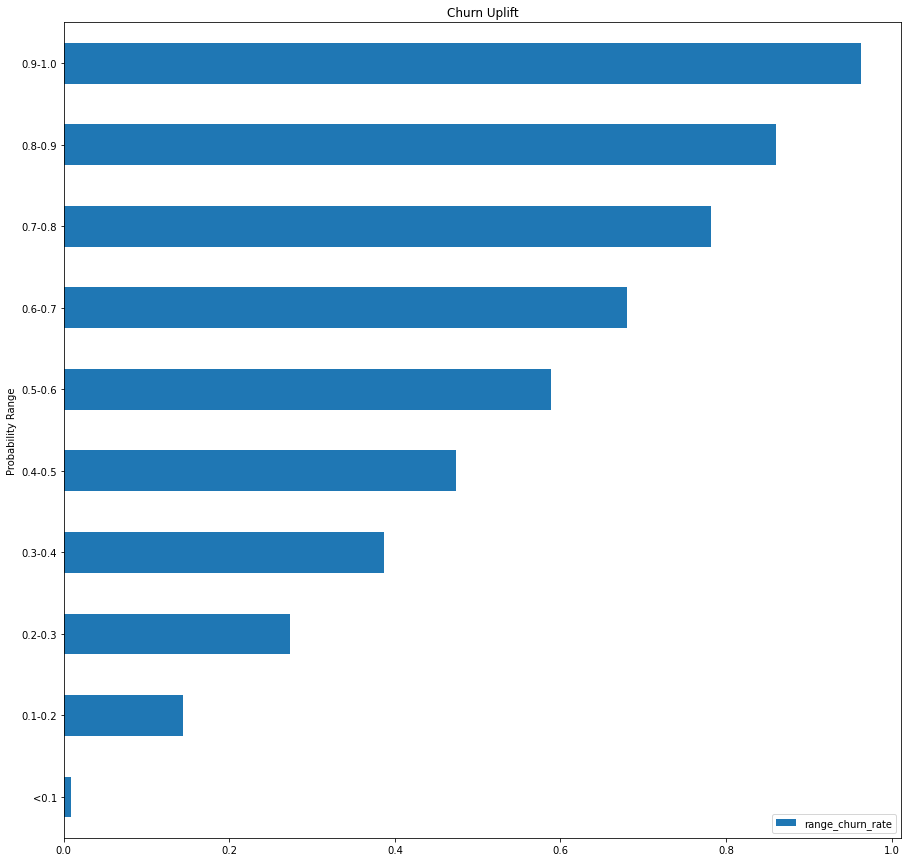

In [5]:
churn_lift.plot.barh(x='churn_proba_range', y='range_churn_rate', figsize=[15,15], title='Churn Uplift', xlabel= 'Probability Range', ylabel='Churn Rate'  )

**The previous graph display the churn rate by range of modeled churn probability. We can appreciate that in the top ten percent probability of churning (0.9-1.0), our model can predict efficiently  the churn of 96% of the clients of this bin.**

In [7]:
churn_lift.to_parquet('churn_lift.parquet.gzip', engine='pyarrow', compression='gzip')

## Model Interpretation



### feature importance

In [48]:
scores = final_model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('max_transaction_month', 688.2913274925264),
 ('min_pmethod_renew', 613.8618437250481),
 ('min_plan_days', 367.9872578134487),
 ('max_is_cancel', 235.0023687954319),
 ('max_plan_days', 164.7049914226494),
 ('max_transaction_year', 101.8429775248898),
 ('max_days_to_expire', 68.50020027993038),
 ('mean_plan_days', 61.70081535813799),
 ('max_price_list', 55.461594380369824),
 ('std_price_list', 49.643002775369574),
 ('min_days_to_expire', 49.387399969766435),
 ('std_pmethod_renew', 42.53194349337275),
 ('mean_pmethod_renew', 38.31625059534766),
 ('sum_plan_days', 27.033335964745802),
 ('max_transaction_day', 24.97763345184924),
 ('max_pmethod_renew', 24.226749892272103),
 ('sum_pmethod_renew', 21.810425256175485),
 ('max_renew', 20.248629133892482),
 ('min_amount_paid', 19.937846588166426),
 ('sum_payment_id', 18.948462319338006),
 ('max_amount_paid', 16.682578161022988),
 ('std_days_to_expire', 16.473749097434208),
 ('sum_price_list', 16.222320981916255),
 ('count_renew', 15.680262628

In [49]:
scores = final_model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('max_transaction_day', 6566),
 ('max_days_to_expire', 5864),
 ('std_days_to_expire', 4755),
 ('sum_days_to_expire', 3779),
 ('min_days_to_expire', 3581),
 ('mean_days_to_expire', 3202),
 ('registration_init_day', 2697),
 ('min_unq_ratio', 2304),
 ('std_unq_ratio', 2291),
 ('sum_plan_days', 2099),
 ('registration_init_month', 2043),
 ('std_skip985_ratio', 2024),
 ('sum_payment_id', 1976),
 ('mean_unq_ratio', 1965),
 ('std_skip50_ratio', 1963),
 ('std_skip25_ratio', 1891),
 ('std_skip75_ratio', 1854),
 ('std_skip_ratio', 1851),
 ('min_total_secs', 1821),
 ('std_amount_paid', 1646),
 ('bd', 1621),
 ('city', 1602),
 ('mean_price_list', 1593),
 ('mean_amount_paid', 1559),
 ('min_payment_id', 1558),
 ('max_num_25', 1547),
 ('mean_payment_id', 1532),
 ('mean_skip985_ratio', 1475),
 ('max_skip985_secs_ratio', 1453),
 ('max_skip50_secs_ratio', 1407),
 ('mean_skip25_ratio', 1405),
 ('mean_skip75_ratio', 1392),
 ('sum_price_list', 1389),
 ('max_skip25_secs_ratio', 1376),
 ('max_num_unq', 1361),

In [50]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

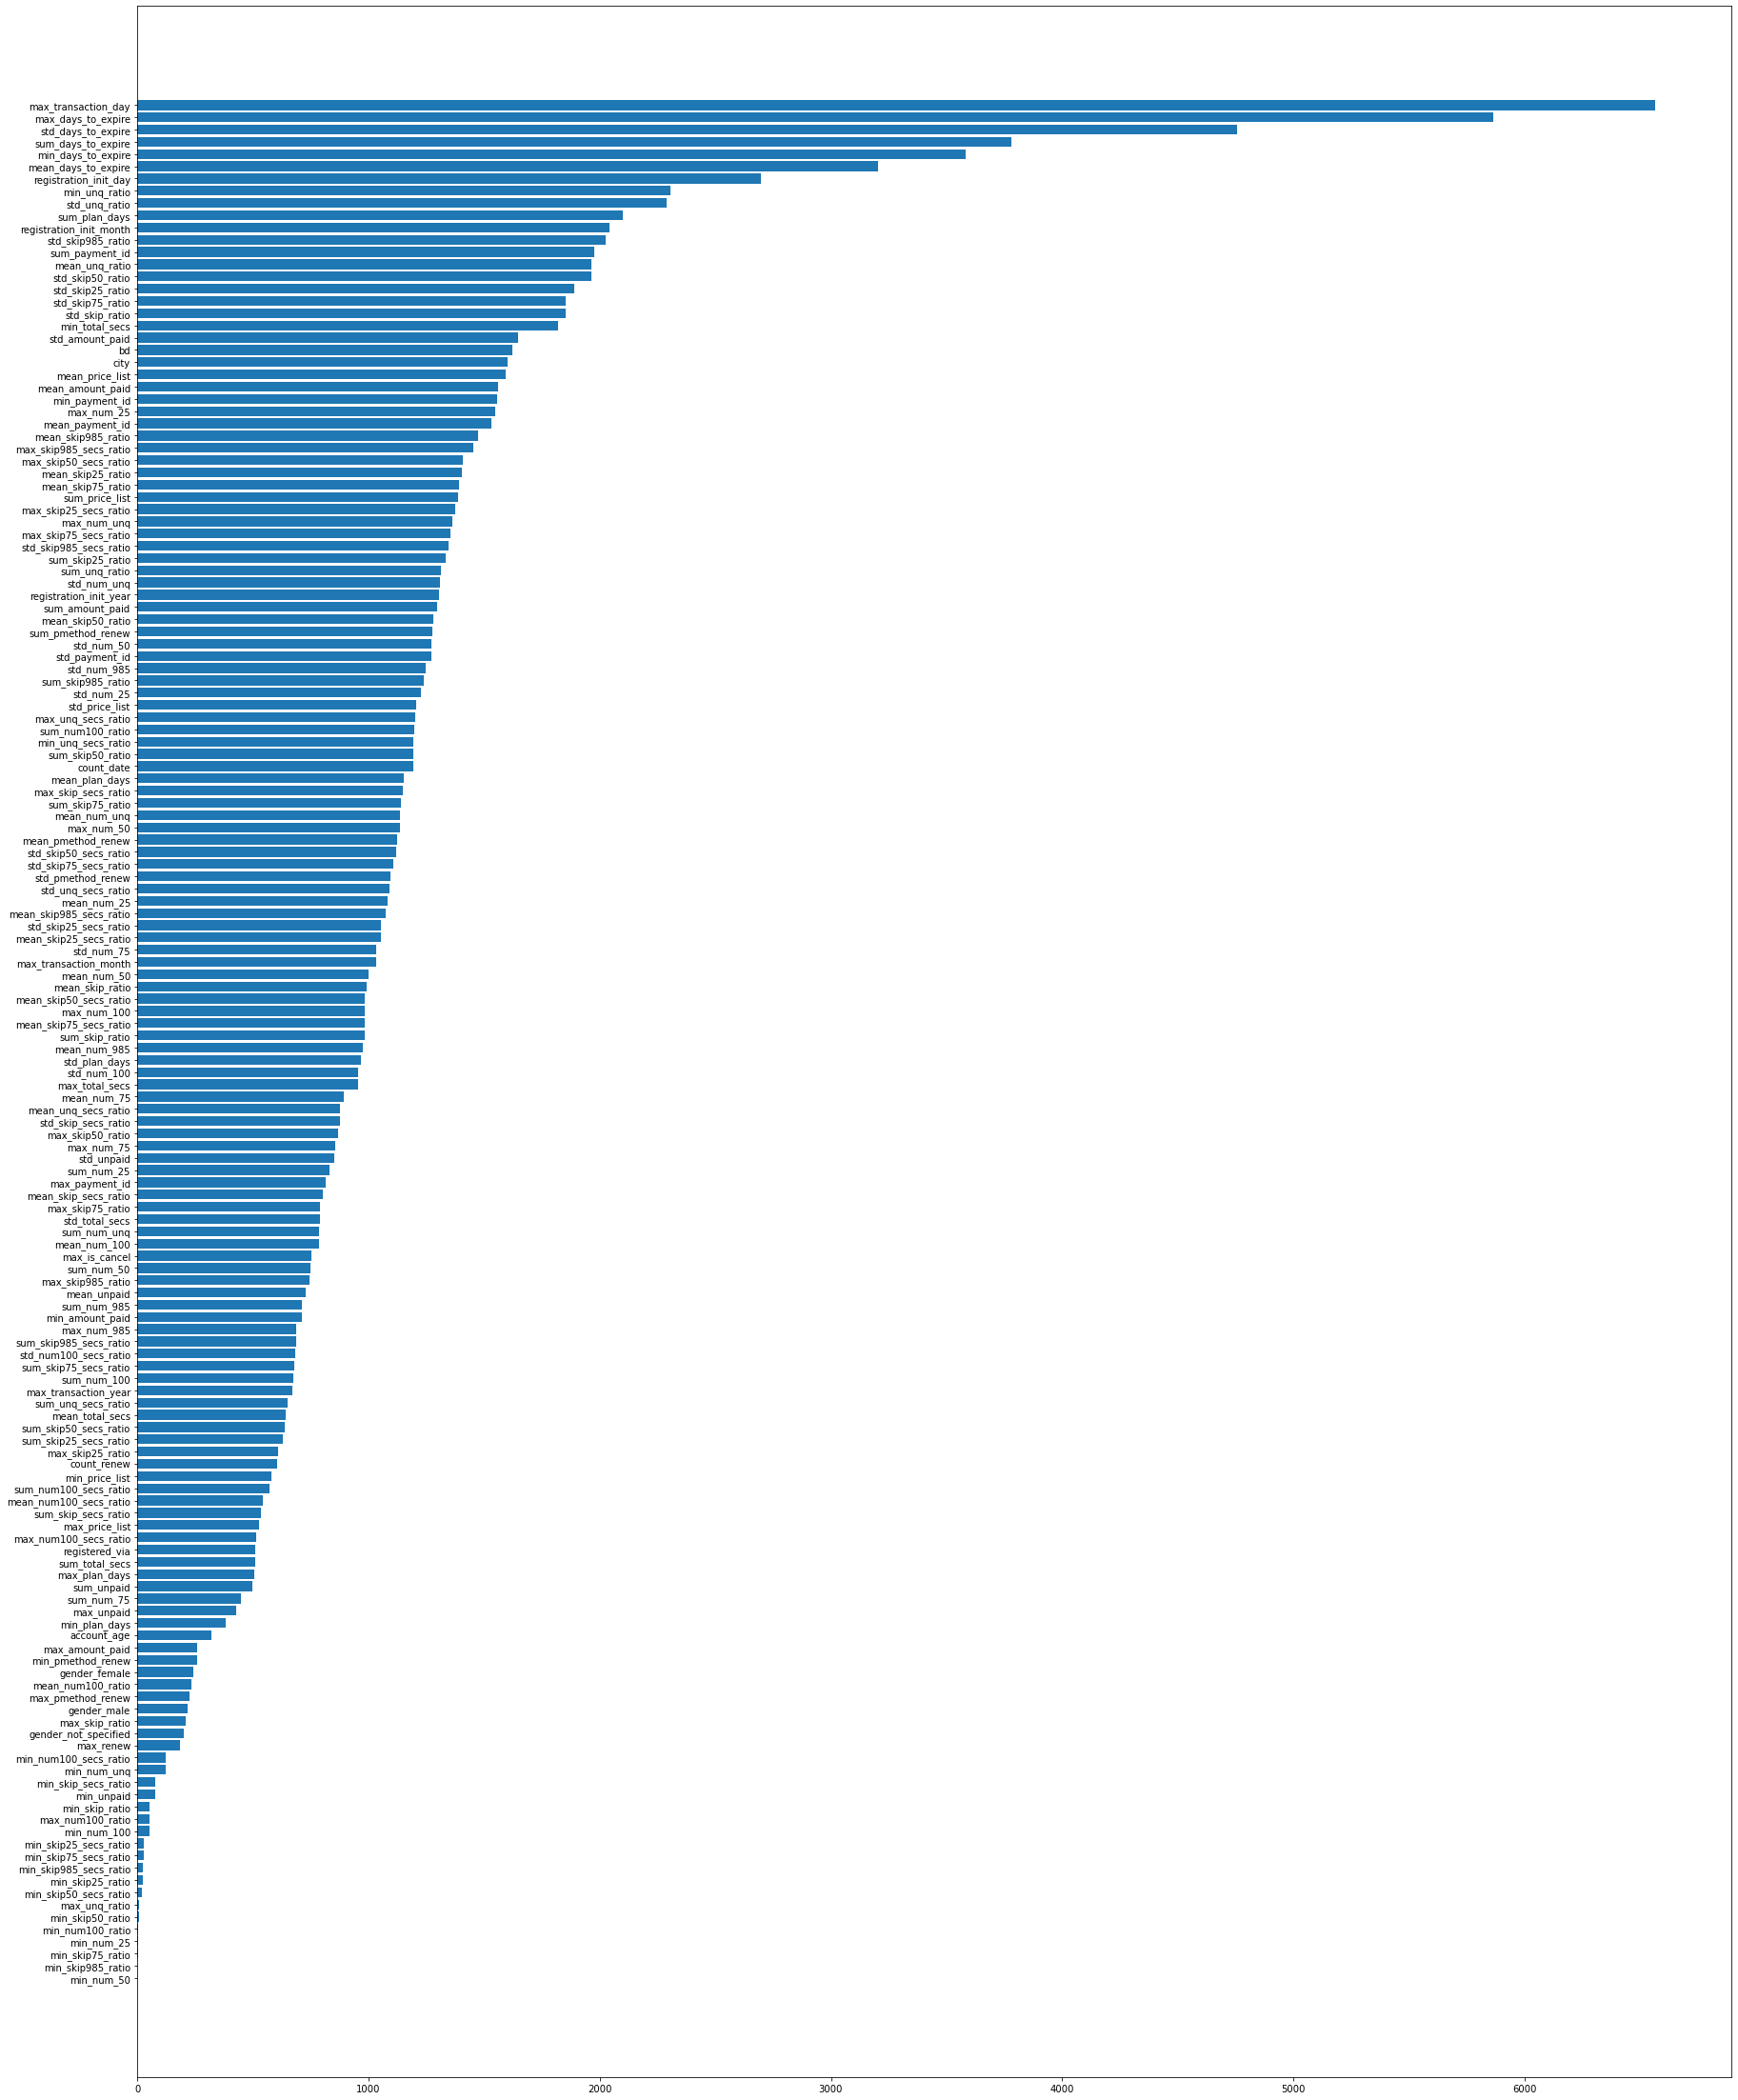

In [51]:
plt.figure(figsize=(30, 40))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

In [56]:
%%time
bins = [ 0,1, np.inf]
names = ['churned', 'not_churned']

y_test_fr['churn_label'] = pd.cut(y_test_fr['is_churn_x'], bins, labels=names)

display(y_test_fr.dtypes)

is_churn_x                             int64
PROBABILITY                          float32
msno                                  object
is_churn_y                             int64
city                                   int64
bd                                     int64
gender                              category
registered_via                         int64
registration_init_time        datetime64[ns]
min_payment_id                         int64
max_payment_id                         int64
mean_payment_id                      float64
std_payment_id                       float64
sum_payment_id                         int64
min_plan_days                          int64
max_plan_days                          int64
mean_plan_days                       float64
std_plan_days                        float64
sum_plan_days                          int64
min_price_list                         int64
max_price_list                         int64
mean_price_list                      float64
std_price_

CPU times: user 13 ms, sys: 24 µs, total: 13 ms
Wall time: 11.4 ms


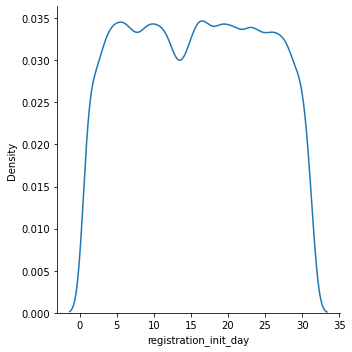

In [8]:
sns.displot(y_test_fr, x="registration_init_day", kind="kde")

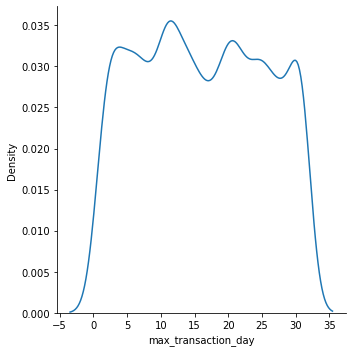

In [89]:
sns.displot(test_visual, x="max_transaction_day", kind="kde")

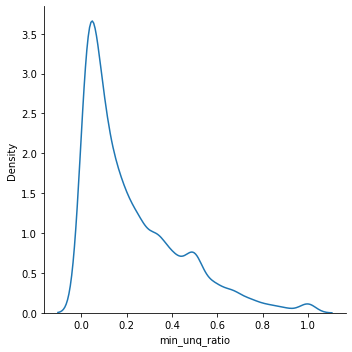

In [90]:
sns.displot(test_visual, x="min_unq_ratio", kind="kde")

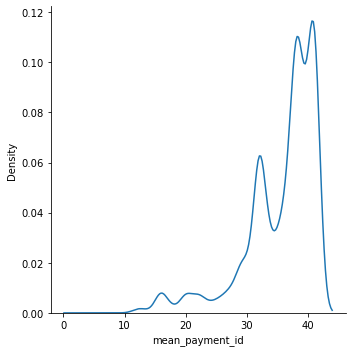

In [91]:
sns.displot(test_visual, x="mean_payment_id", kind="kde")

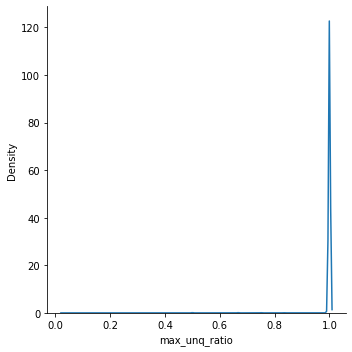

In [9]:
sns.displot(y_test_fr, x="max_unq_ratio", kind="kde")

/home/rene/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


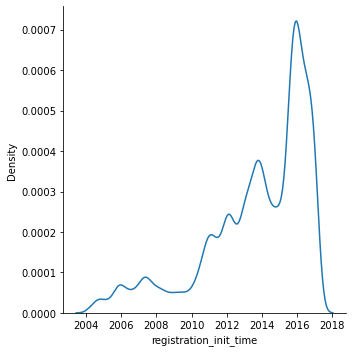

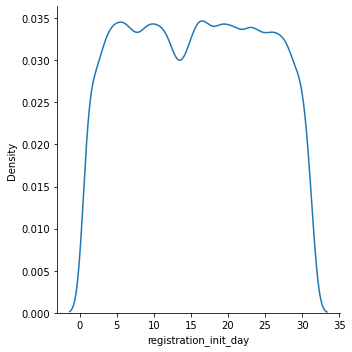

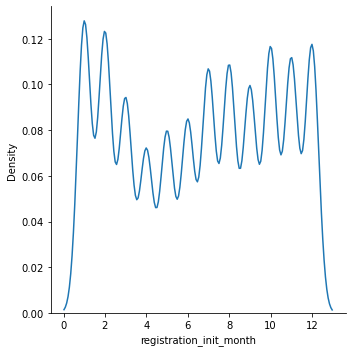

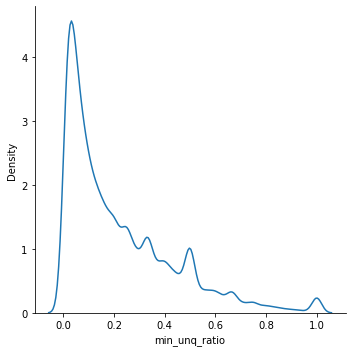

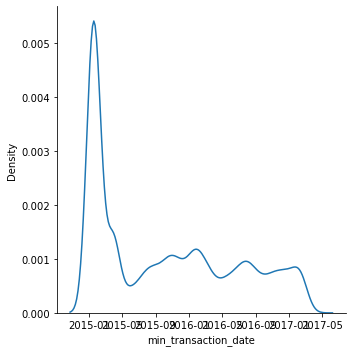

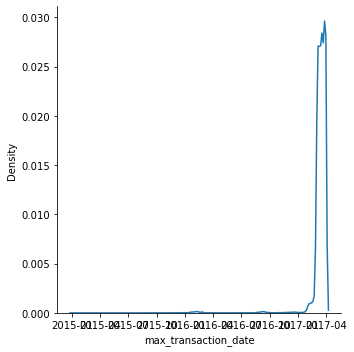

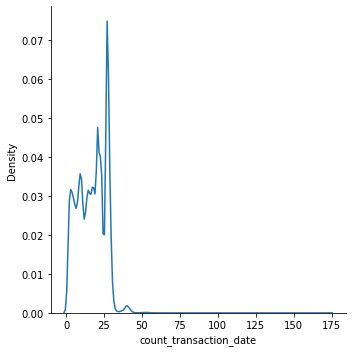

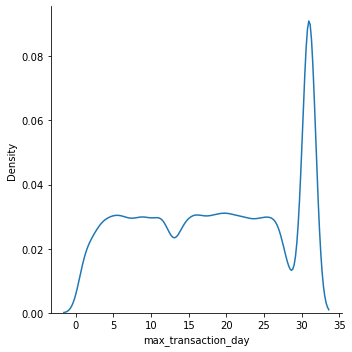

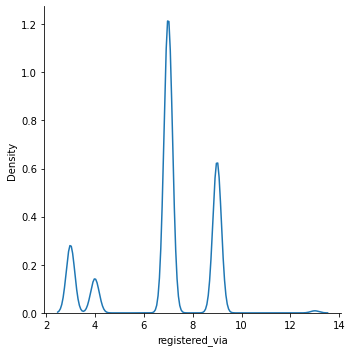

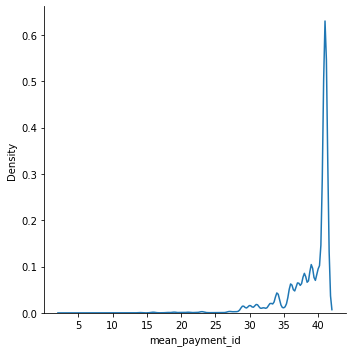

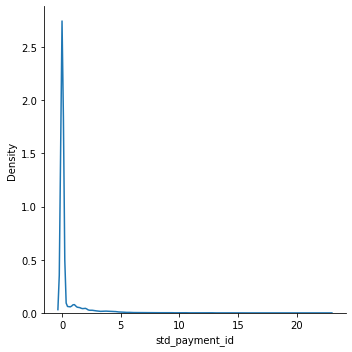

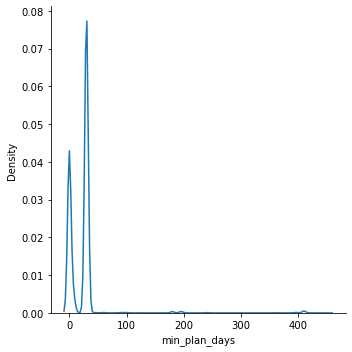

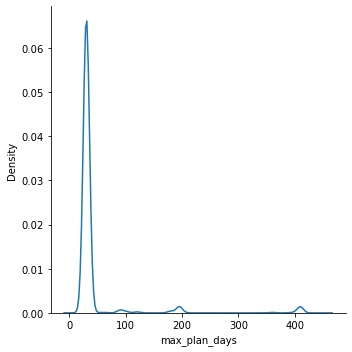

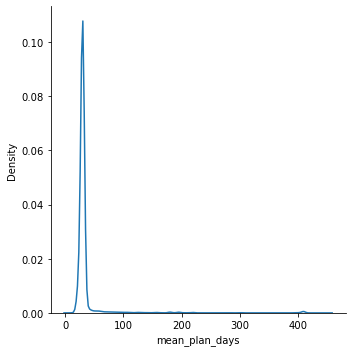

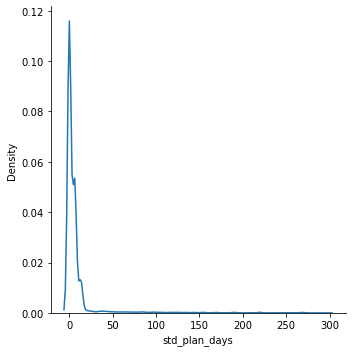

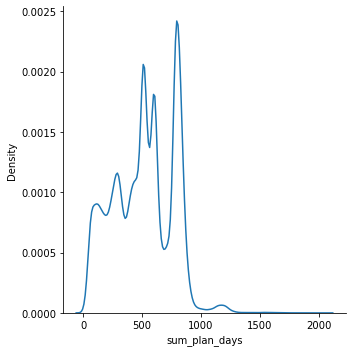

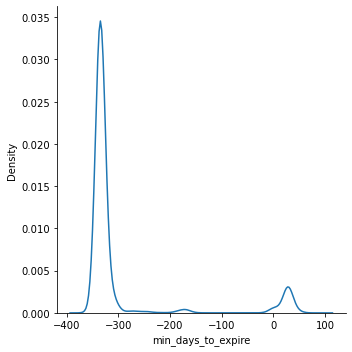

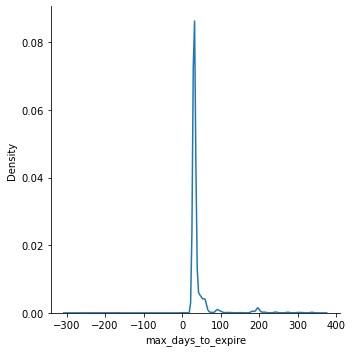

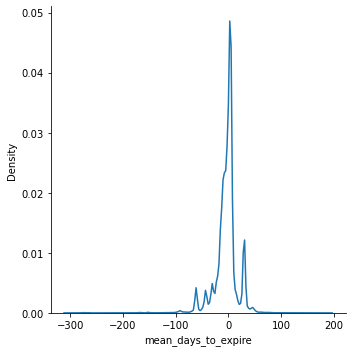

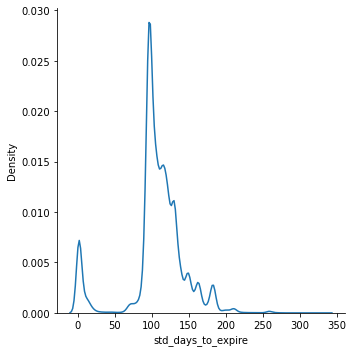

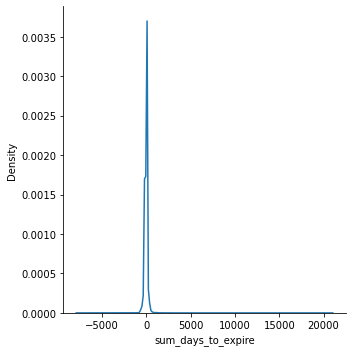

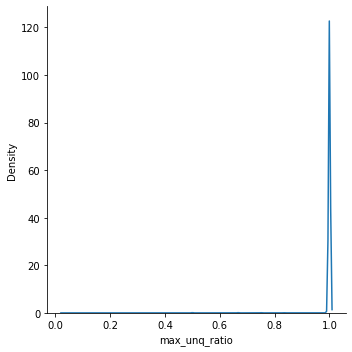

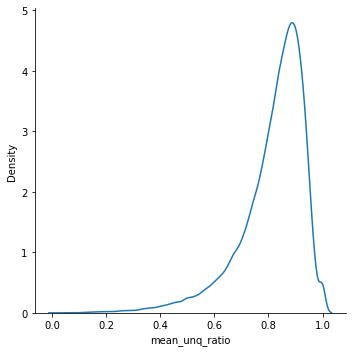

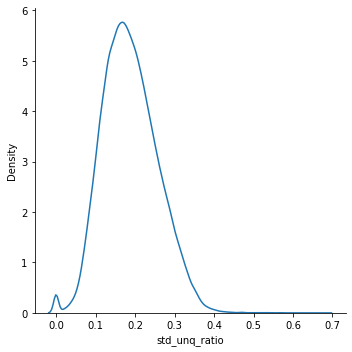

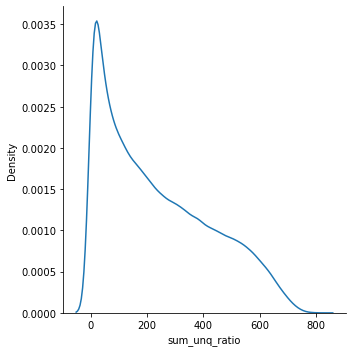

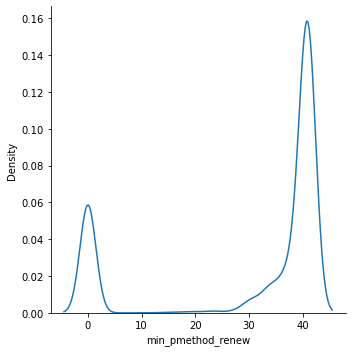

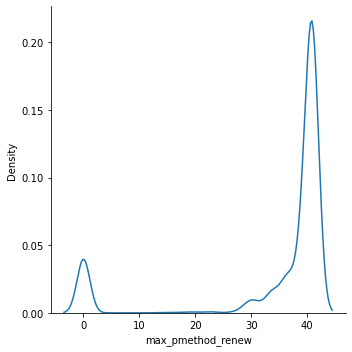

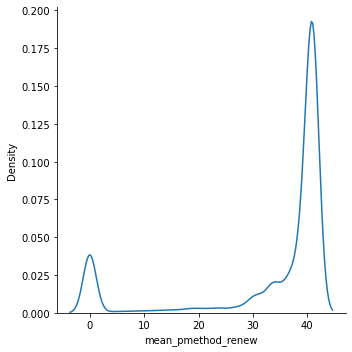

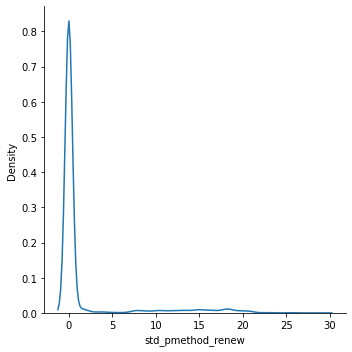

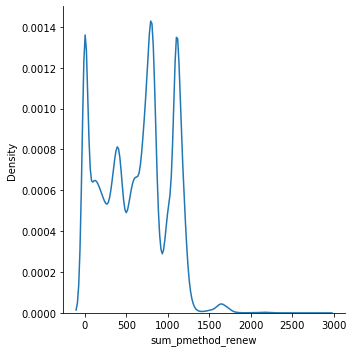

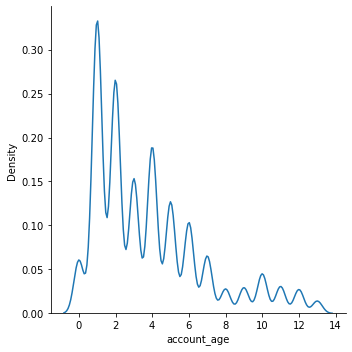

In [10]:
col_list=['registration_init_time', 'registration_init_day', 'registration_init_month',
        'min_unq_ratio', 
        'min_transaction_date', 'max_transaction_date', 'count_transaction_date', 
        'max_transaction_day', 
        'registered_via', 
        'mean_payment_id', 'std_payment_id', 
        'min_plan_days', 'max_plan_days', 'mean_plan_days', 'std_plan_days', 'sum_plan_days',
        'min_days_to_expire', 'max_days_to_expire', 'mean_days_to_expire', 'std_days_to_expire', 
        'sum_days_to_expire', 
        'max_unq_ratio', 'mean_unq_ratio', 'std_unq_ratio', 'sum_unq_ratio',
        'min_pmethod_renew', 'max_pmethod_renew', 'mean_pmethod_renew', 'std_pmethod_renew', 
        'sum_pmethod_renew',
        'account_age']

for column in col_list:
    sns.displot(y_test_fr, x=column, kind="kde")